In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error,mean_squared_error
from sklearn.preprocessing import StandardScaler


In [2]:
plt.rc('font', family='Times New Roman')
plt.rcParams['figure.dpi'] = 600

In [3]:
def pbias(predicted, observed):
    return 100.0 * np.sum(observed - predicted) / np.sum(observed)

def nmae(predicted, observed):
    return 100 * mean_absolute_error(observed, predicted) / np.mean(observed)

def evaluate_model(
    y_train=None, y_pred_train=None,
    y_test=None, y_pred_test=None,
    y_holdout=None, y_pred_holdout=None,
    xlabel='Observed', ylabel='Predicted',
    units='', xlim=(3.5, 18), ylim=(3.5, 18),
    hue=None, text="Train", label = None,
    p =.35, # x axis location of validation text , could be .02, .35 or .65
    legend_outside=False
):

    metrics = {}

    plt.figure(figsize=(8, 6))
    

    # --- Train Plot ---
    if y_train is not None and y_pred_train is not None:
        metrics["Train"] = {
            "rmse": np.sqrt(mean_squared_error(y_train, y_pred_train)),
#             "nmae": nmae(y_pred_train, y_train),
#             "pbias": pbias(y_pred_train, y_train),
            "r2": r2_score(y_train, y_pred_train)
        }

        sns.scatterplot(x=y_train, y=y_pred_train, label="Train", color="blue", edgecolor="k")
        sns.regplot(x=y_train, y=y_pred_train, scatter=False, ci=None, color="blue",label="Train regression line" )

        plt.annotate(
            f"Train Set:\nRMSE: {metrics['Train']['rmse']:.2f}\n"
#             f"NMAE: {metrics['Train']['nmae']:.2f}%\n"
#             f"PBIAS: {metrics['Train']['pbias']:.2f}%\n"
            f"$R^2$: {metrics['Train']['r2']:.2f}",
            xy=(0.02, 0.86), xycoords='axes fraction', fontsize=14
        )

    # --- Test Plot ---
    if y_test is not None and y_pred_test is not None:
        metrics["Test"] = {
            "rmse": np.sqrt(mean_squared_error(y_test, y_pred_test)),
#             "nmae": nmae(y_pred_test, y_test),
#             "pbias": pbias(y_pred_test, y_test),
            "r2": r2_score(y_test, y_pred_test)
        }

        sns.scatterplot(x=y_test, y=y_pred_test, label="Test", color="red", edgecolor="k")
        sns.regplot(x=y_test, y=y_pred_test, scatter=False, ci=None, color="red", label="Test regression line")

        plt.annotate(
            f"Test Set:\nRMSE: {metrics['Test']['rmse']:.2f}\n"
#             f"NMAE: {metrics['Test']['nmae']:.2f}%\n"
#             f"PBIAS: {metrics['Test']['pbias']:.2f}%\n"
            f"$R^2$: {metrics['Test']['r2']:.2f}",
            xy=(0.65, 0.86), xycoords='axes fraction', fontsize=14
        )

    # --- Holdout Plot ---
    if y_holdout is not None and y_pred_holdout is not None:
        metrics["Holdout"] = {
            "rmse": np.sqrt(mean_squared_error(y_holdout, y_pred_holdout)),
            "nmae": nmae(y_pred_holdout, y_holdout),
            "pbias": pbias(y_pred_holdout, y_holdout),
            "r2": r2_score(y_holdout, y_pred_holdout)
        }
        


        sns.scatterplot(x=y_holdout, y=y_pred_holdout, label=label, color="green", edgecolor="k", hue=hue)
        sns.regplot(x=y_holdout, y=y_pred_holdout, scatter=False, ci=None, color="green", label="Holdout regression line")

        plt.annotate(
            f"Holdout {text}:\nRMSE: {metrics['Holdout']['rmse']:.2f}\n"
            f"NMAE: {metrics['Holdout']['nmae']:.2f}%\n"
            f"PBIAS: {metrics['Holdout']['pbias']:.2f}%\n"
            f"$R^2$: {metrics['Holdout']['r2']:.2f}",
            xy=(p, 0.82), xycoords='axes fraction', fontsize=14
        )

    # Axis and layout
    plt.xlabel(f"{xlabel} ({units})", fontsize=14)
    plt.ylabel(f"{ylabel} ({units})", fontsize=14)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.axline((0, 0), slope=1, label='1:1 line', color='gray', linestyle='--')
    
    if legend_outside:
        plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0)
    else:
        plt.legend(loc='lower right')
        
    plt.tight_layout()
    plt.show()

#     return metrics


In [4]:
df = pd.read_excel("Secondary and Main Data file for machine learning analysis.xlsx")
df.columns = df.columns.str.strip()
df.describe()


Year        NO3-        NH4+          pH          TDS  \
count   134.000000  134.000000  134.000000  134.000000   134.000000   
mean   2018.283582    7.017164    0.556687    7.627537   945.271716   
std       1.236123   16.609820    0.937026    0.242085   651.220631   
min    2017.000000    0.000000    0.000000    7.050000   229.980000   
25%    2017.000000    0.000000    0.000000    7.452500   553.750000   
50%    2018.000000    1.190000    0.124500    7.620000   835.575000   
75%    2020.000000    5.650000    0.696600    7.770000  1199.467500   
max    2020.000000   96.050000    5.662000    8.340000  4998.000000   

             Ca2+        Mg2+          K+         Na+        Mn2+         TFe  \
count  134.000000  134.000000  134.000000  134.000000  134.000000  134.000000   
mean    85.016343   66.034701    3.906269  151.792687    0.257246    1.098910   
std     54.063432   41.934890    2.888545  134.225002    0.379647    1.986021   
min     23.090000   12.600000    1.000000   16.000000    0.000000    0.010000   
25%     47.030000   31.852500    2.000000   69.590000    0.036000    0.110000   
50%     72.070000   60.215000    3.000000  126.350000    0.079500    0.210000   
75%    105.557500   81.590000    4.500000  180.000000    0.326750    1.110000   
max    428.400000  225.000000   22.000000  932.200000    2.090000   12.270000   

               Cl-        SO42-       HCO3-       CODMn          F-  \
count   134.000000   134.000000  134.000000  134.000000  134.000000   
mean    153.806390   252.416493  406.764482    1.394977    0.511598   
std     177.045168   266.578772  154.159477    0.942981    0.584739   
min      20.170000     8.850000  150.909685    0.000000    0.030000   
25%      73.638523   109.127500  263.872500    0.826057    0.232944   
50%     117.529531   178.515000  368.047408    1.233557    0.376447   
75%     194.792627   313.055000  534.553462    1.624562    0.700000   
max    1680.869274  1852.000000  768.267488    8.820000    5.941709   

       Well depth  
count  134.000000  
mean    56.637313  
std     64.530708  
min      3.580000  
25%     12.000000  
50%     23.420000  
75%    102.760000  
max    249.020000

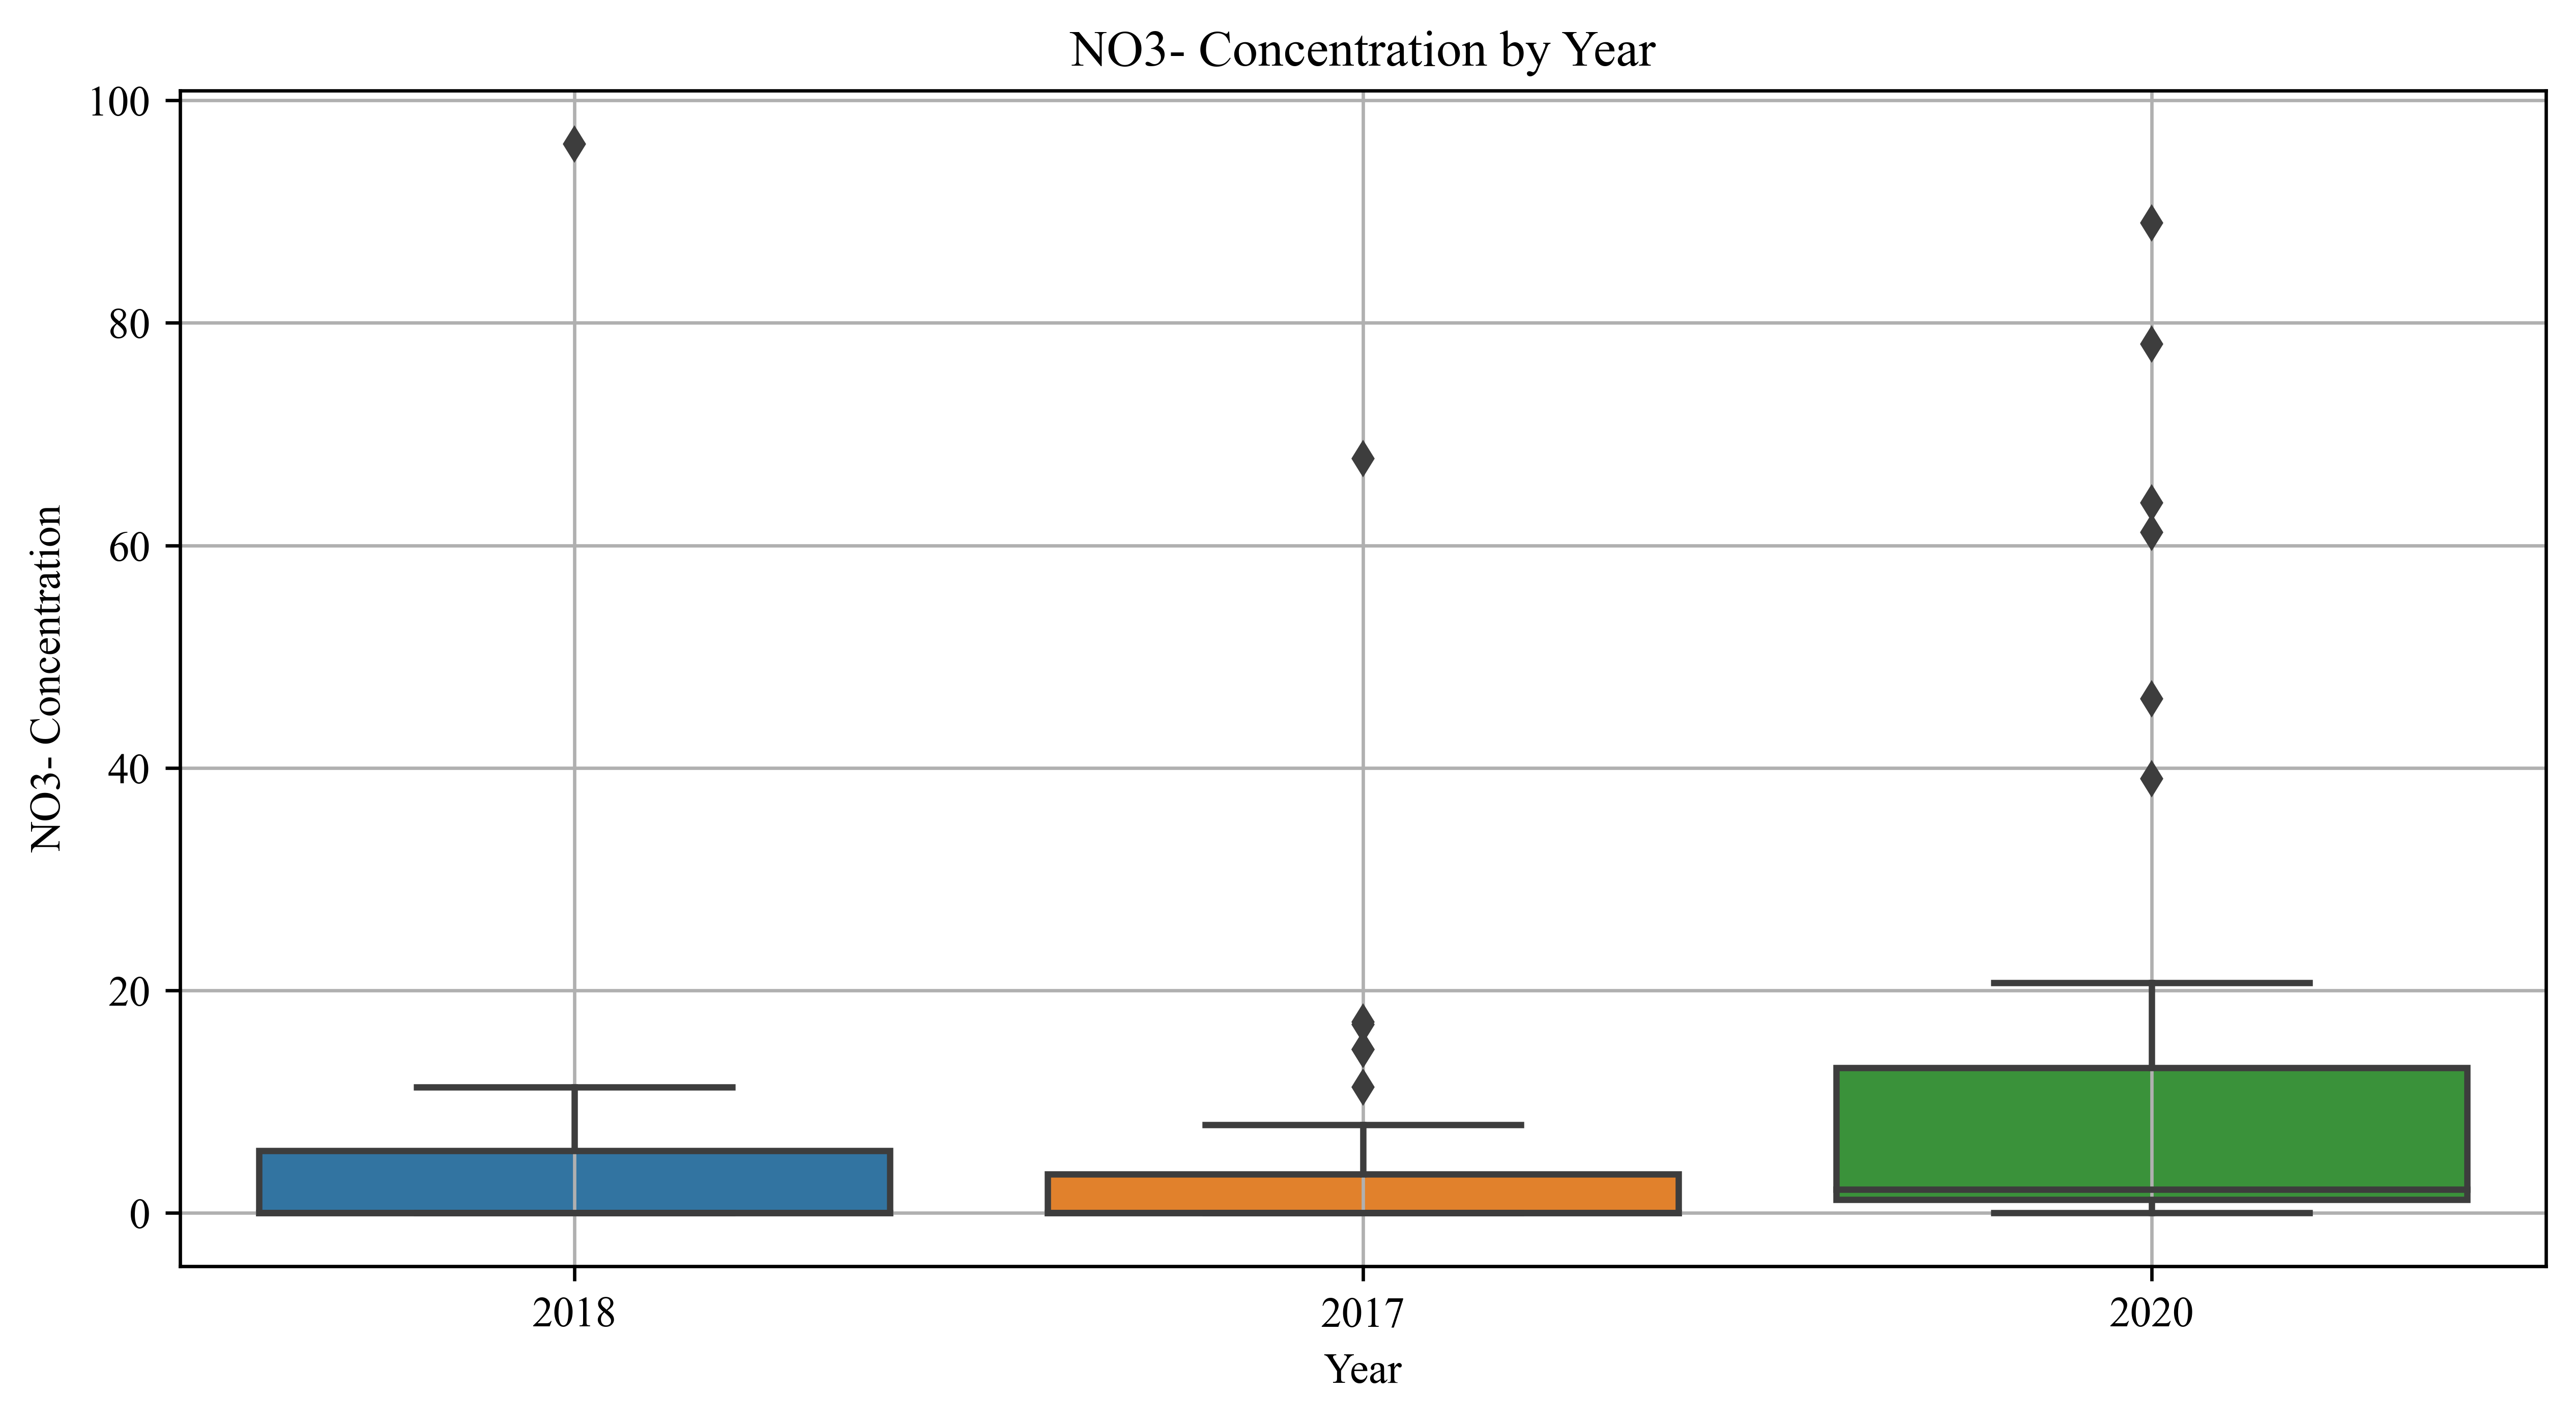

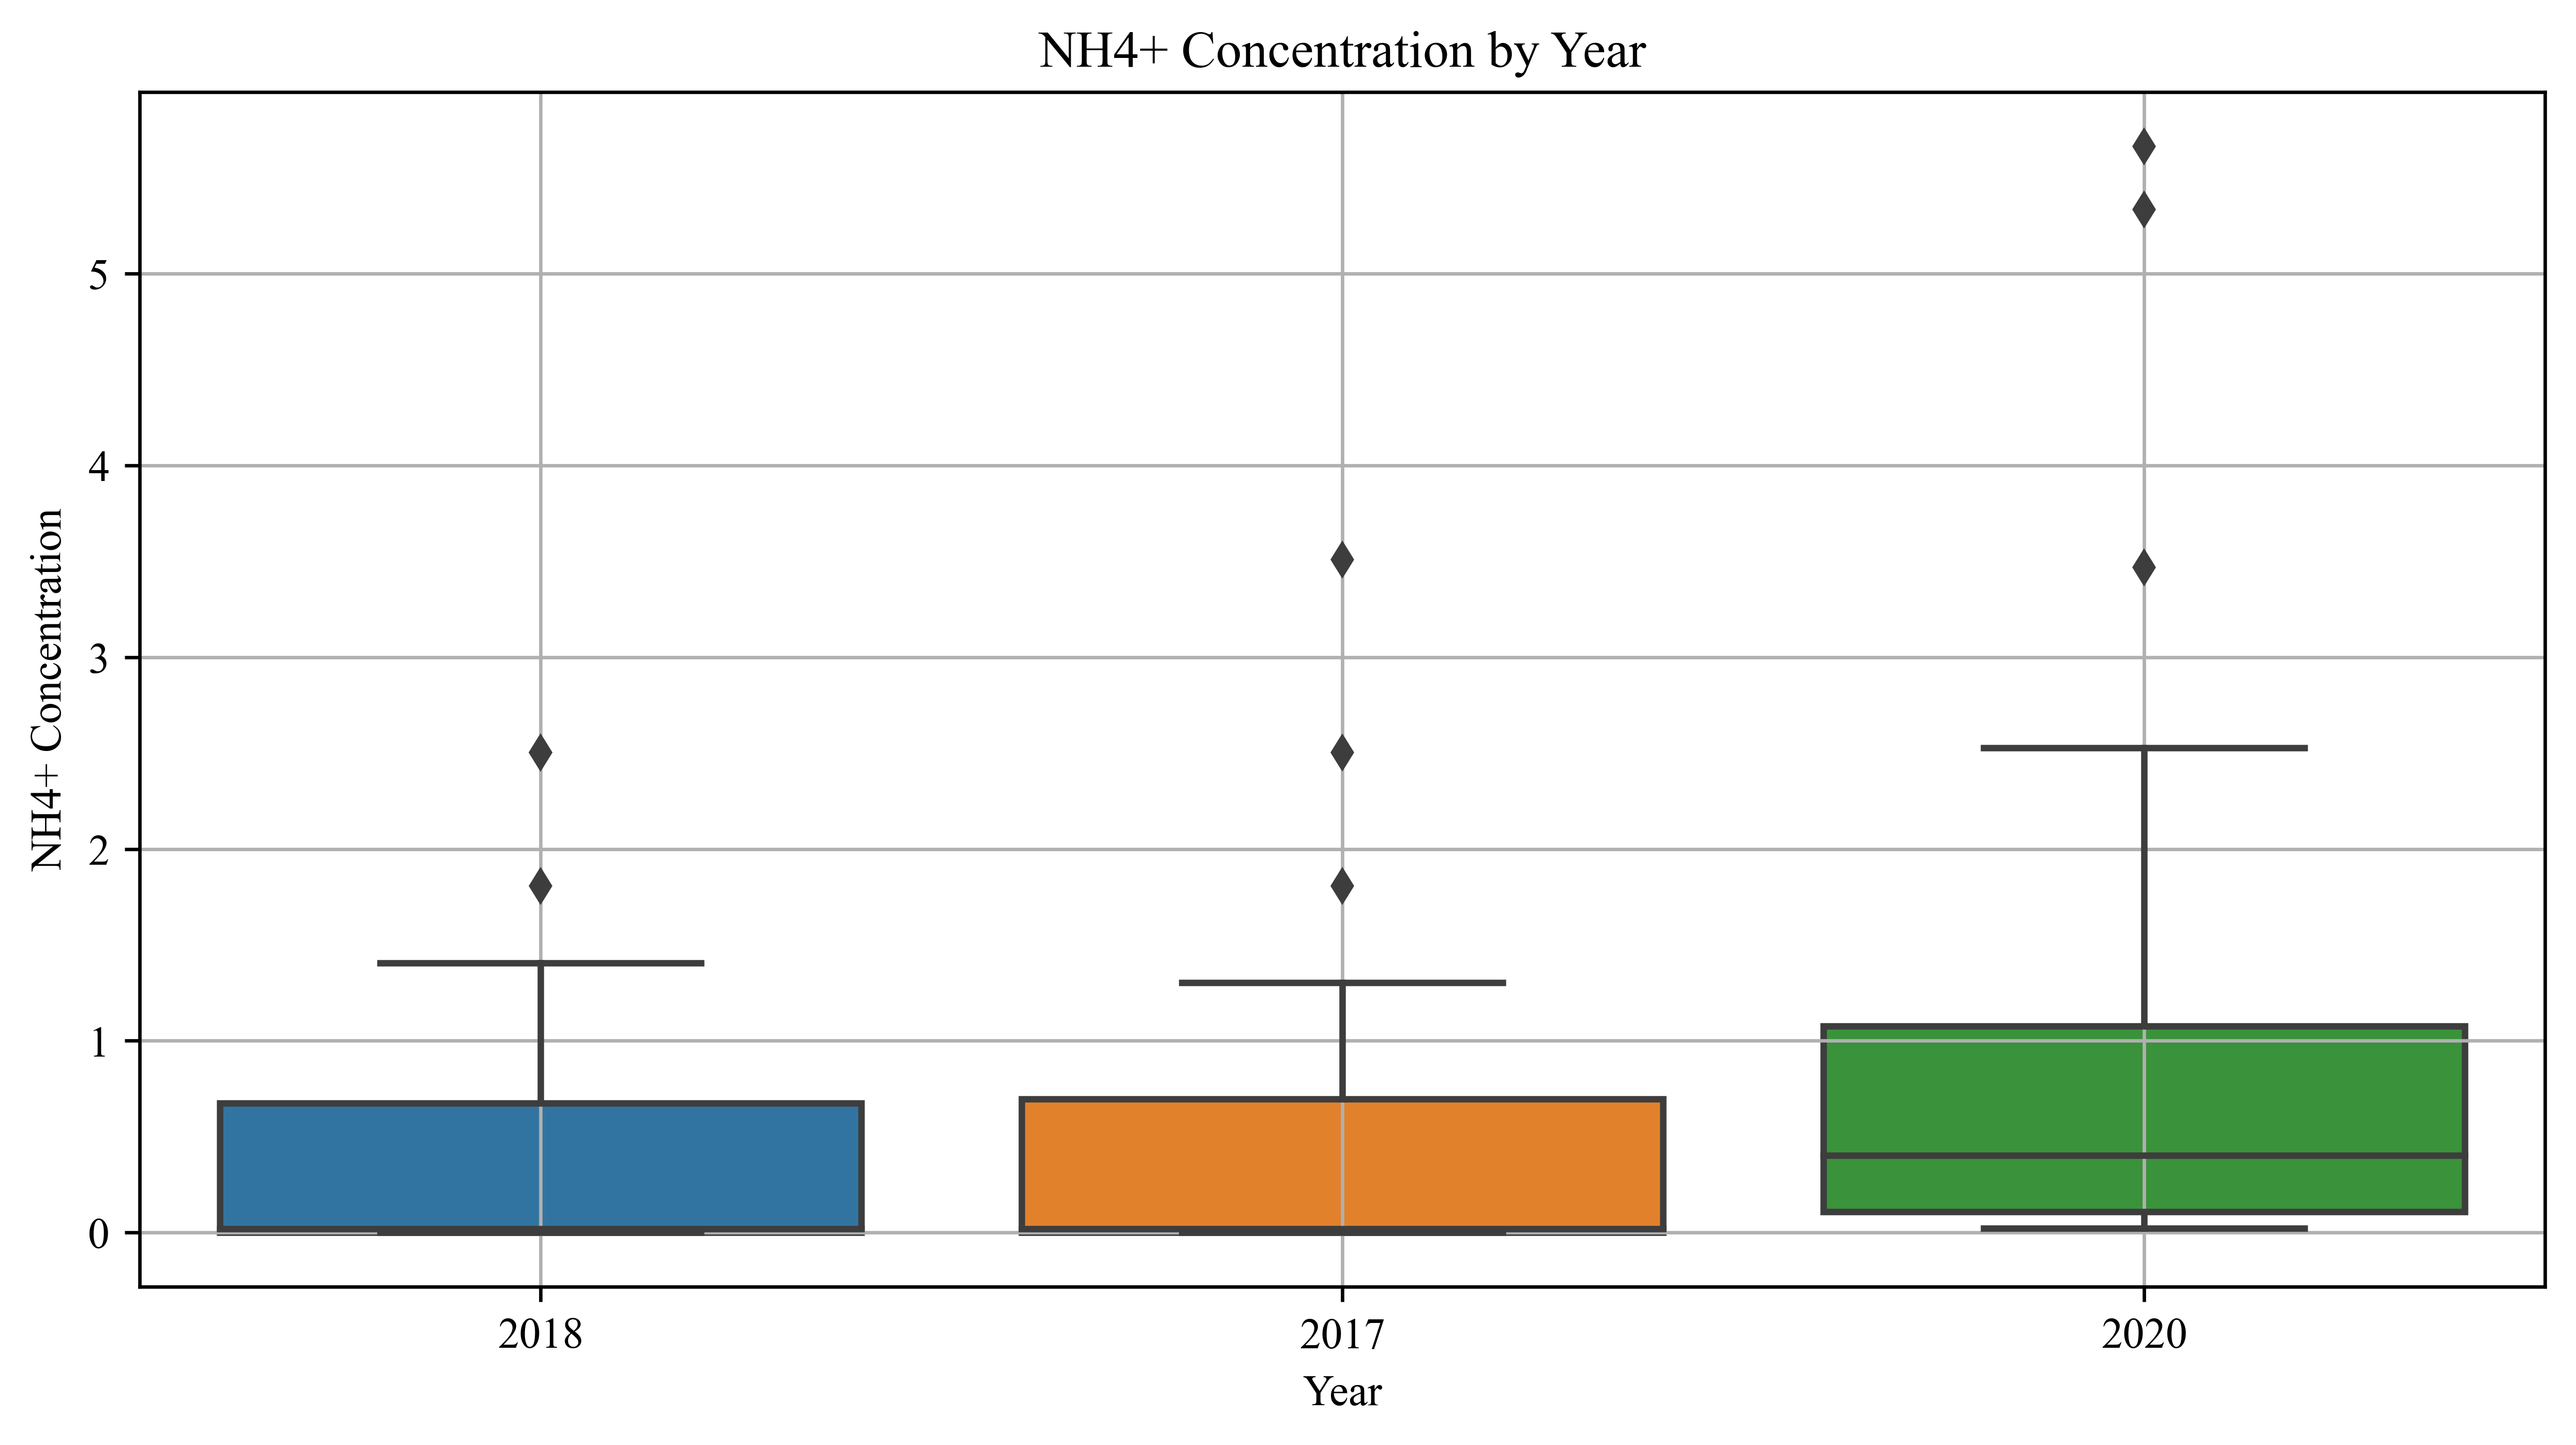

In [5]:


# Make sure 'Year' is treated as a category for clean x-axis labeling
df["Year"] = df["Year"].astype(str)

# Box plot for NO3-
plt.figure(figsize=(10, 5))
sns.boxplot(x="Year", y="NO3-", data=df)
plt.title("NO3- Concentration by Year")
plt.xlabel("Year")
plt.ylabel("NO3- Concentration")
plt.grid(True)
plt.show()

# Box plot for NH4+
plt.figure(figsize=(10, 5))
sns.boxplot(x="Year", y="NH4+", data=df)
plt.title("NH4+ Concentration by Year")
plt.xlabel("Year")
plt.ylabel("NH4+ Concentration")
plt.grid(True)
plt.show()


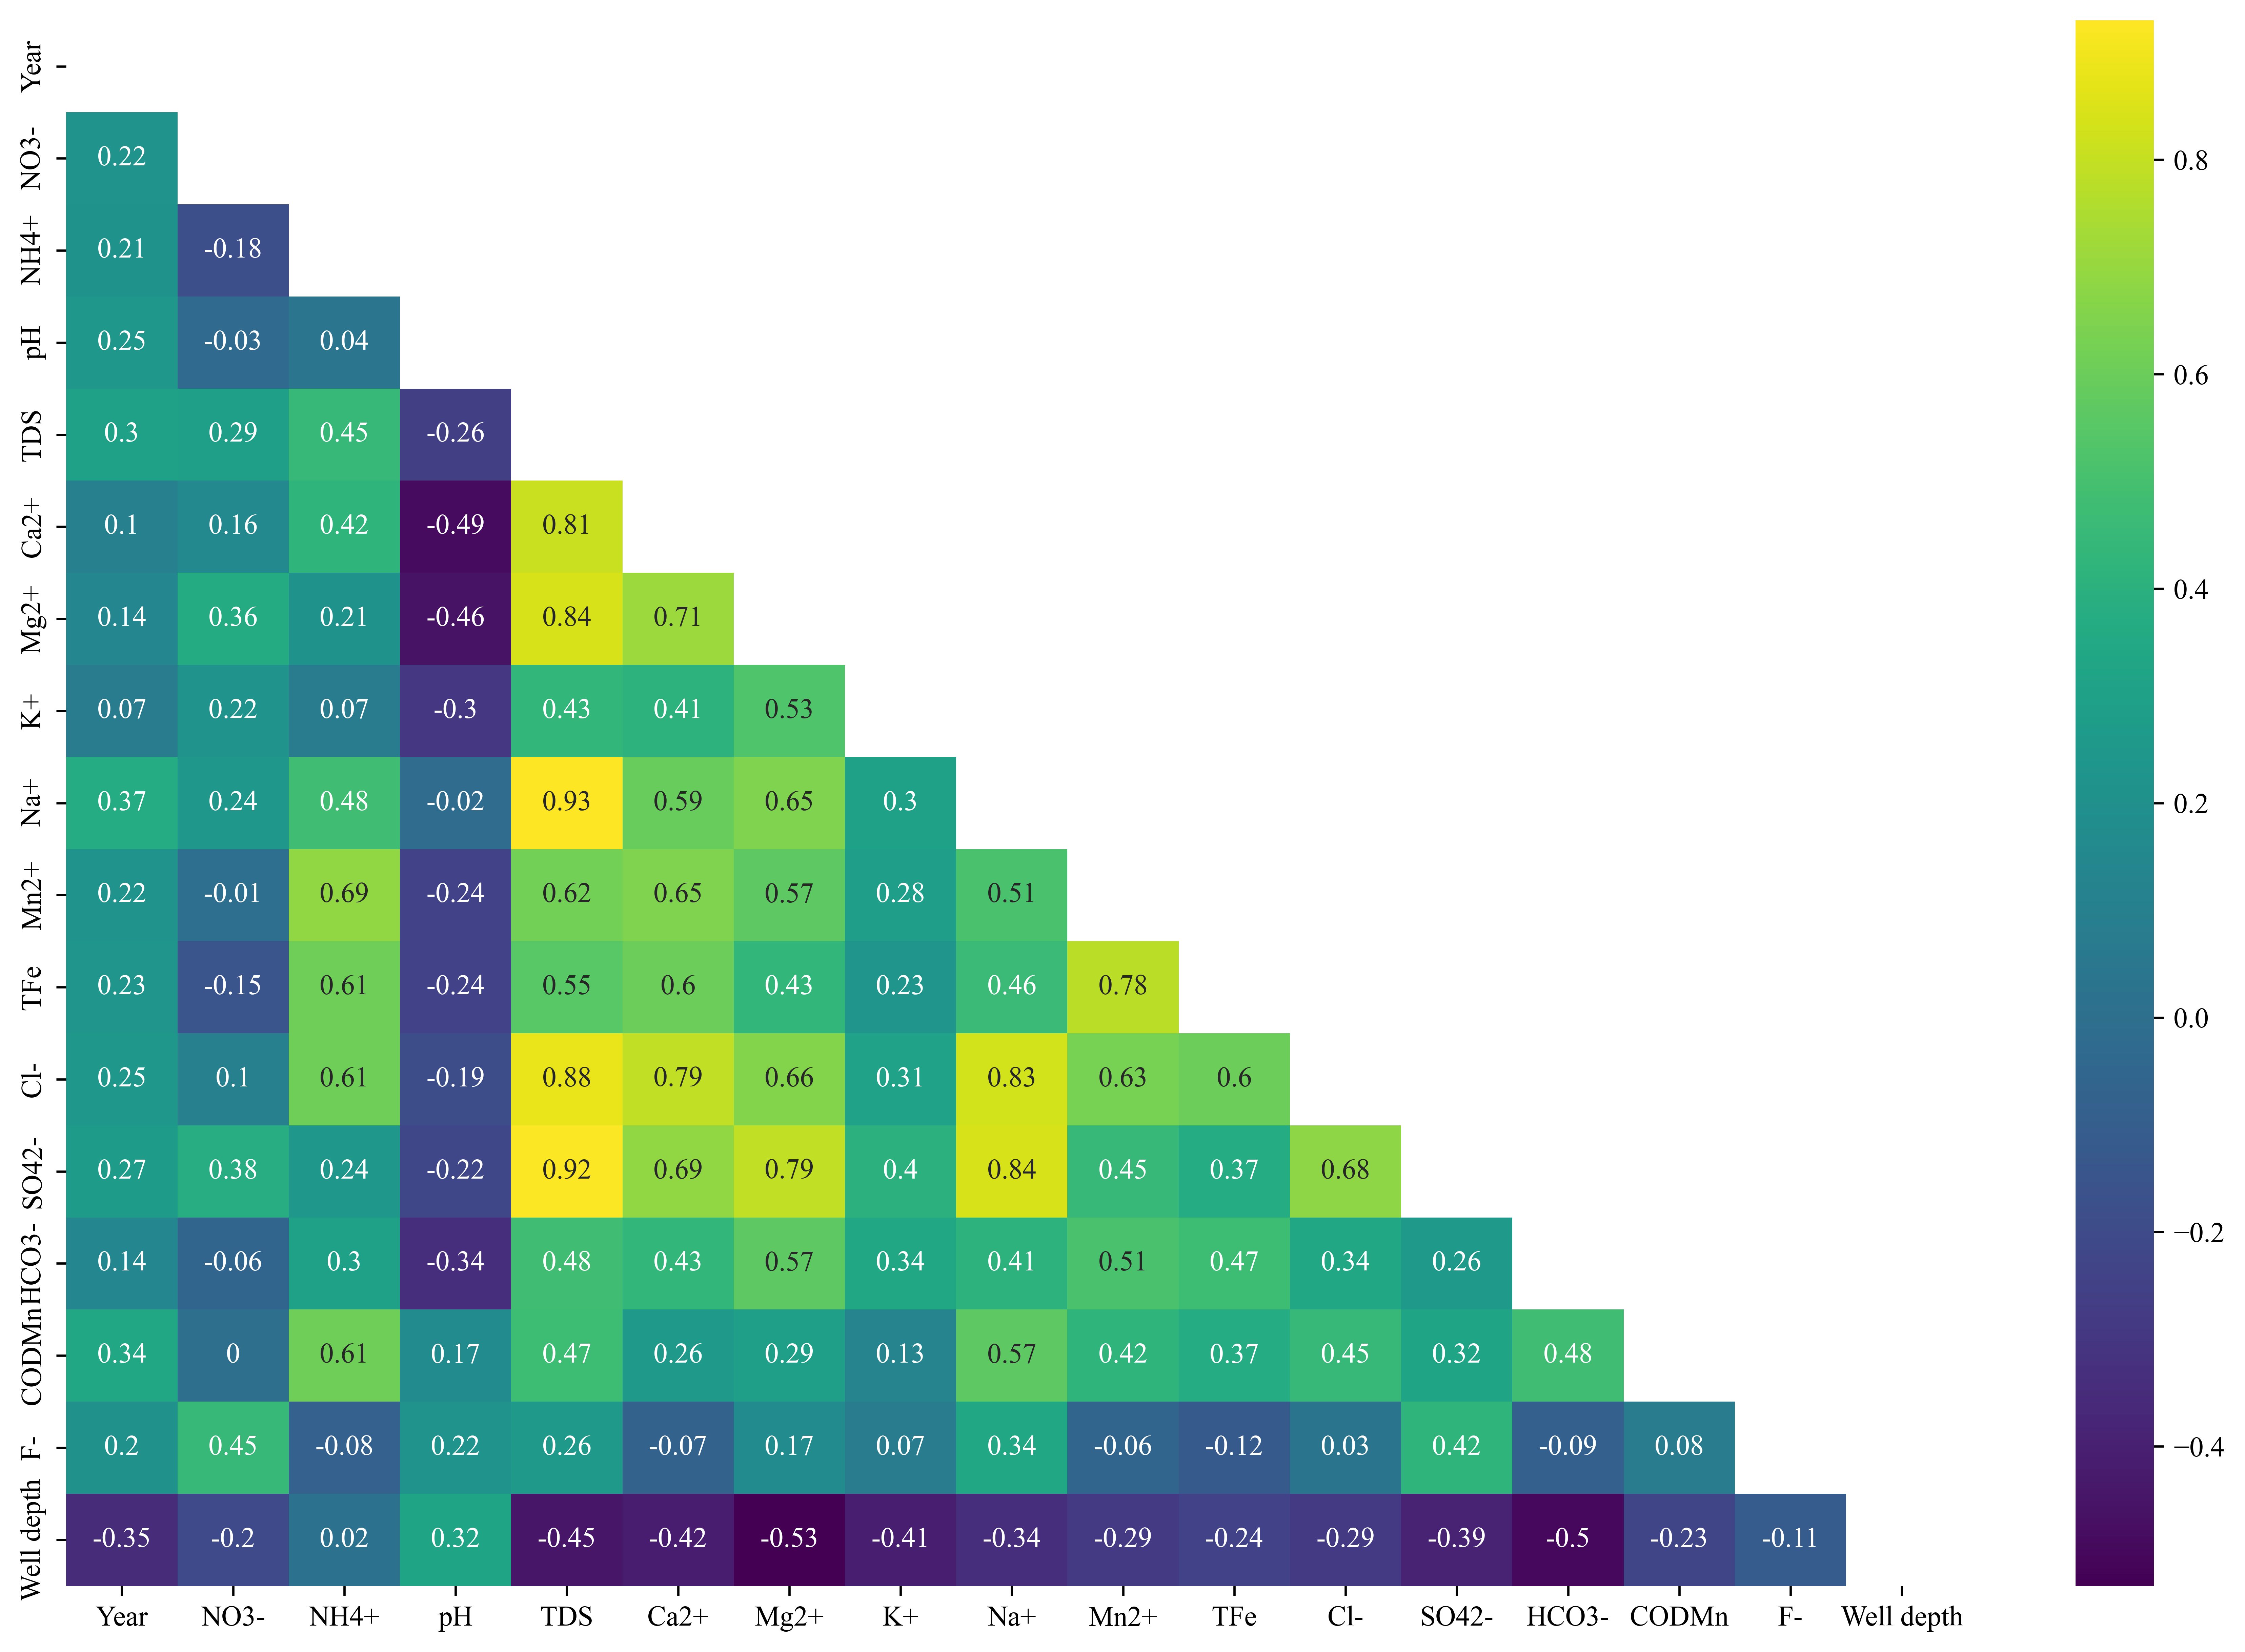

In [6]:
def corr_plot(data,
              top_visible = False, right_visible = False, 
              bottom_visible = True, left_visible = False,
              ylabel = None, figsize = (15,10), axis_grid = 'y'):
    fig, ax = plt.subplots(figsize = figsize)
#     plt.title('Correlations (Pearson)', size = 15, fontweight = 'bold', fontfamily = 'serif')
    
    mask = np.triu(np.ones_like(data.corr(), dtype = bool))
    sns.heatmap(round(data.corr(), 2), mask = mask, cmap = 'viridis', annot = True)
    plt.show()

corr_plot(df)

## No3 model

In [7]:

X = df.iloc[:, 2:]  # assuming features start from column index 2
y = df["NO3-"]
years = df["Year"].astype(int)

# Step 2: Split by year
# X_train = X[years.isin([2017, 2018])]
# y_train = y[years.isin([2017, 2018])]
# X_test = X[years == 2020]
# y_test = y[years == 2020]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=172)
X_train

NH4+    pH      TDS    Ca2+    Mg2+     K+     Na+   Mn2+    TFe  \
121  0.3630  7.41  1107.00   92.62   86.99   5.33  152.80  0.012  0.163   
107  0.2280  7.50  1195.00  118.70   89.22  14.81  158.10  0.063  5.670   
119  0.0310  7.86   551.00   43.19   43.78   2.31   78.36  0.001  0.013   
16   0.0645  7.71   250.66   32.03   20.64   2.00   30.00  0.020  0.160   
67   0.0000  7.49   764.92  121.46   52.61   3.00   74.40  0.069  0.270   
..      ...   ...      ...     ...     ...    ...     ...    ...    ...   
86   0.0000  7.62   877.74   94.47   73.65   2.00  120.00  0.315  0.120   
125  0.0600  8.11  2541.00  110.30  112.40   3.20  530.30  0.005  0.164   
78   0.0000  7.57   697.88  106.04   57.28   3.00   54.80  0.052  0.110   
66   1.0965  7.65   521.73   23.14   29.23   1.50  126.00  0.066  0.510   
26   0.1032  7.24  1348.27  100.10  148.11   6.50  172.00  0.397  2.750   

            Cl-    SO42-       HCO3-     CODMn        F-  Well depth  
121  153.641957   378.10  423.331065  1.237113  0.482267       25.00  
107  175.966002   270.20  678.113650  1.773196  0.444306       21.00  
119   73.538031   157.80  252.822719  0.989691  0.523471       35.00  
16    26.890000     8.95  223.210000  0.830000  0.300000      160.00  
67   100.830000   142.15  496.200000  1.250000  0.100000       20.00  
..          ...      ...         ...       ...       ...         ...  
86   114.270000   167.54  574.550000  1.370000  0.700000        4.76  
125  292.838944  1304.00  170.508345  1.567010  5.941709       30.00  
78    77.300000   153.26  437.440000  1.220000  0.200000       23.42  
66    73.940000    86.35  326.450000  1.090000  0.900000      108.72  
26   188.220000   360.65  695.890000  0.680000  0.300000        6.00  

[107 rows x 15 columns]

In [8]:
# 4. Define model and scoring
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
xgb_regressor = xgb.XGBRegressor()


param_grid = {
    'n_estimators': [ 50],
    'max_depth': [ 3],
    'learning_rate': [ .1],
    'subsample': [.8],
    'colsample_bytree': [ .9],
    'gamma': [.6],
    "reg_alpha": [.5]
}



# 6. Perform grid search
grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=5,
    n_jobs=7,
    verbose=1
)

grid_search.fit(X_train, y_train)

# 7. Train final model with best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# 8. Predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# 9. Evaluation
def evaluate(y_true, y_pred, label=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- {label} Performance ---")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

evaluate(y_train, y_pred_train, label="Training")
evaluate(y_test, y_pred_test, label="Test")



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0.5, 'subsample': 0.8}

--- Training Performance ---
MAE: 1.7378
RMSE: 2.6792
R²: 0.9724

--- Test Performance ---
MAE: 4.5723
RMSE: 8.0811
R²: 0.8014


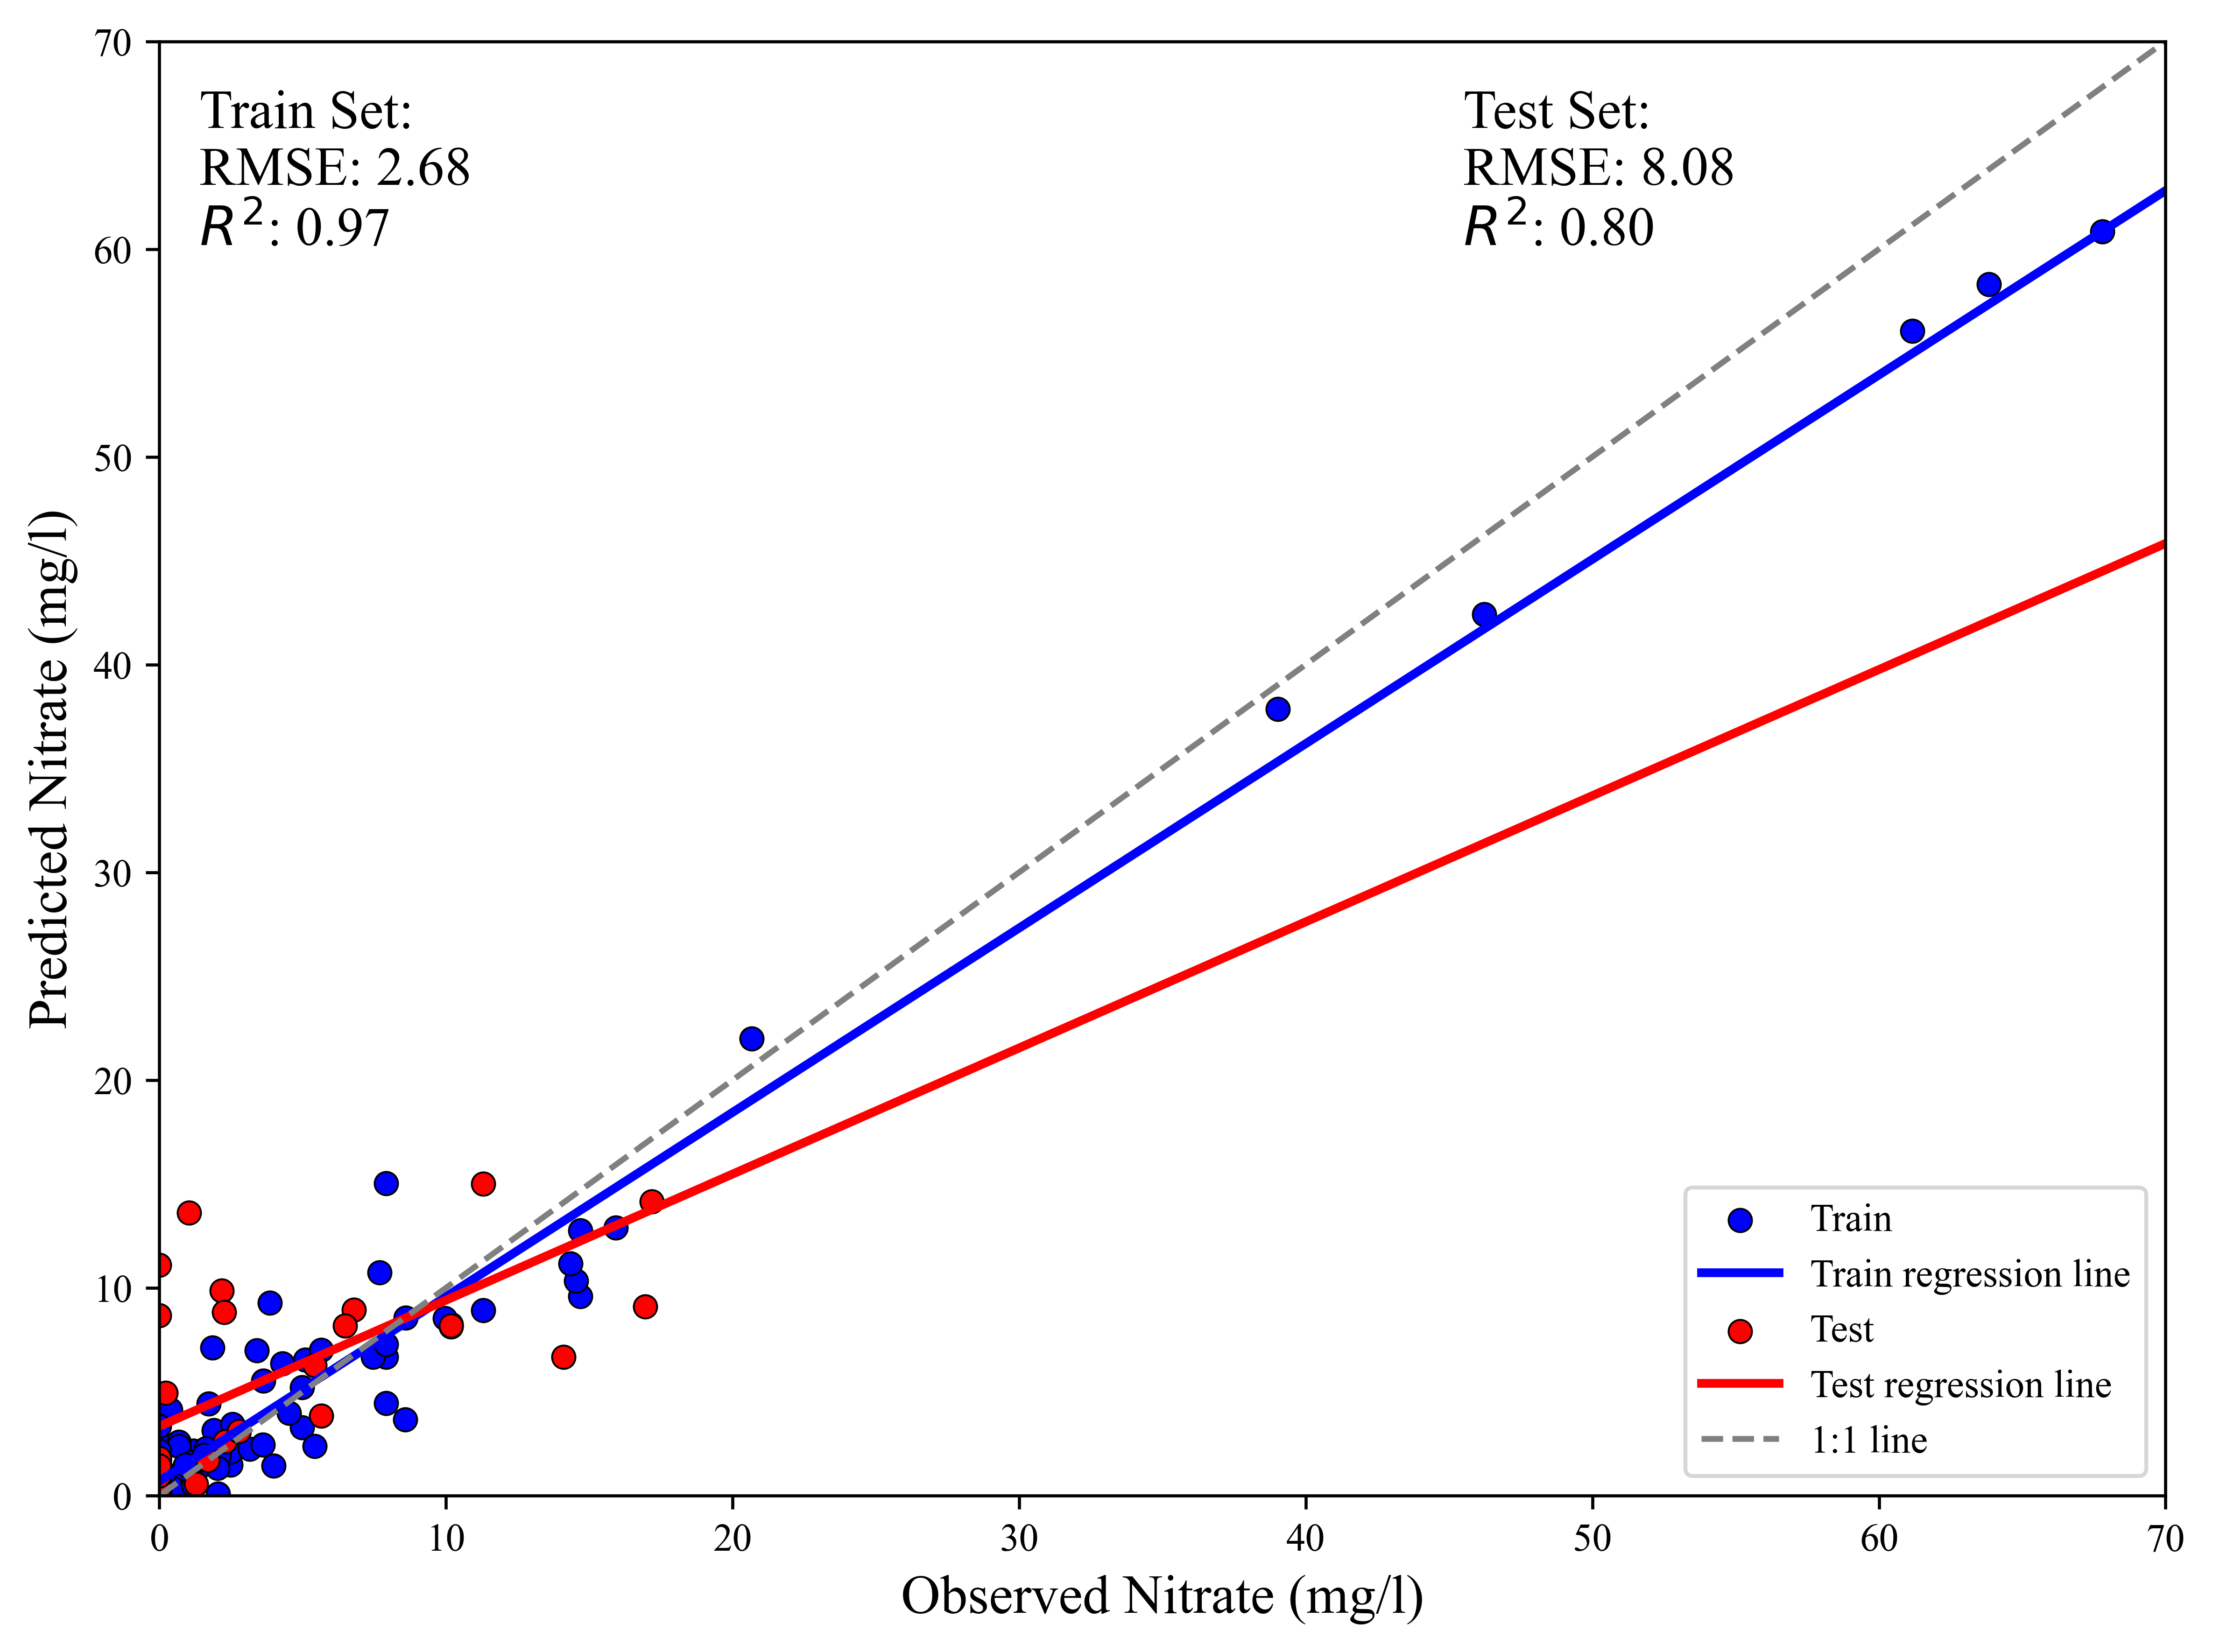

In [9]:
evaluate_model(
    y_train, y_pred_train , 
    y_test, y_pred_test, 
    xlabel='Observed Nitrate', ylabel='Predicted Nitrate', units='mg/l',
    xlim = (0,70), ylim =(0,70) 
    
)


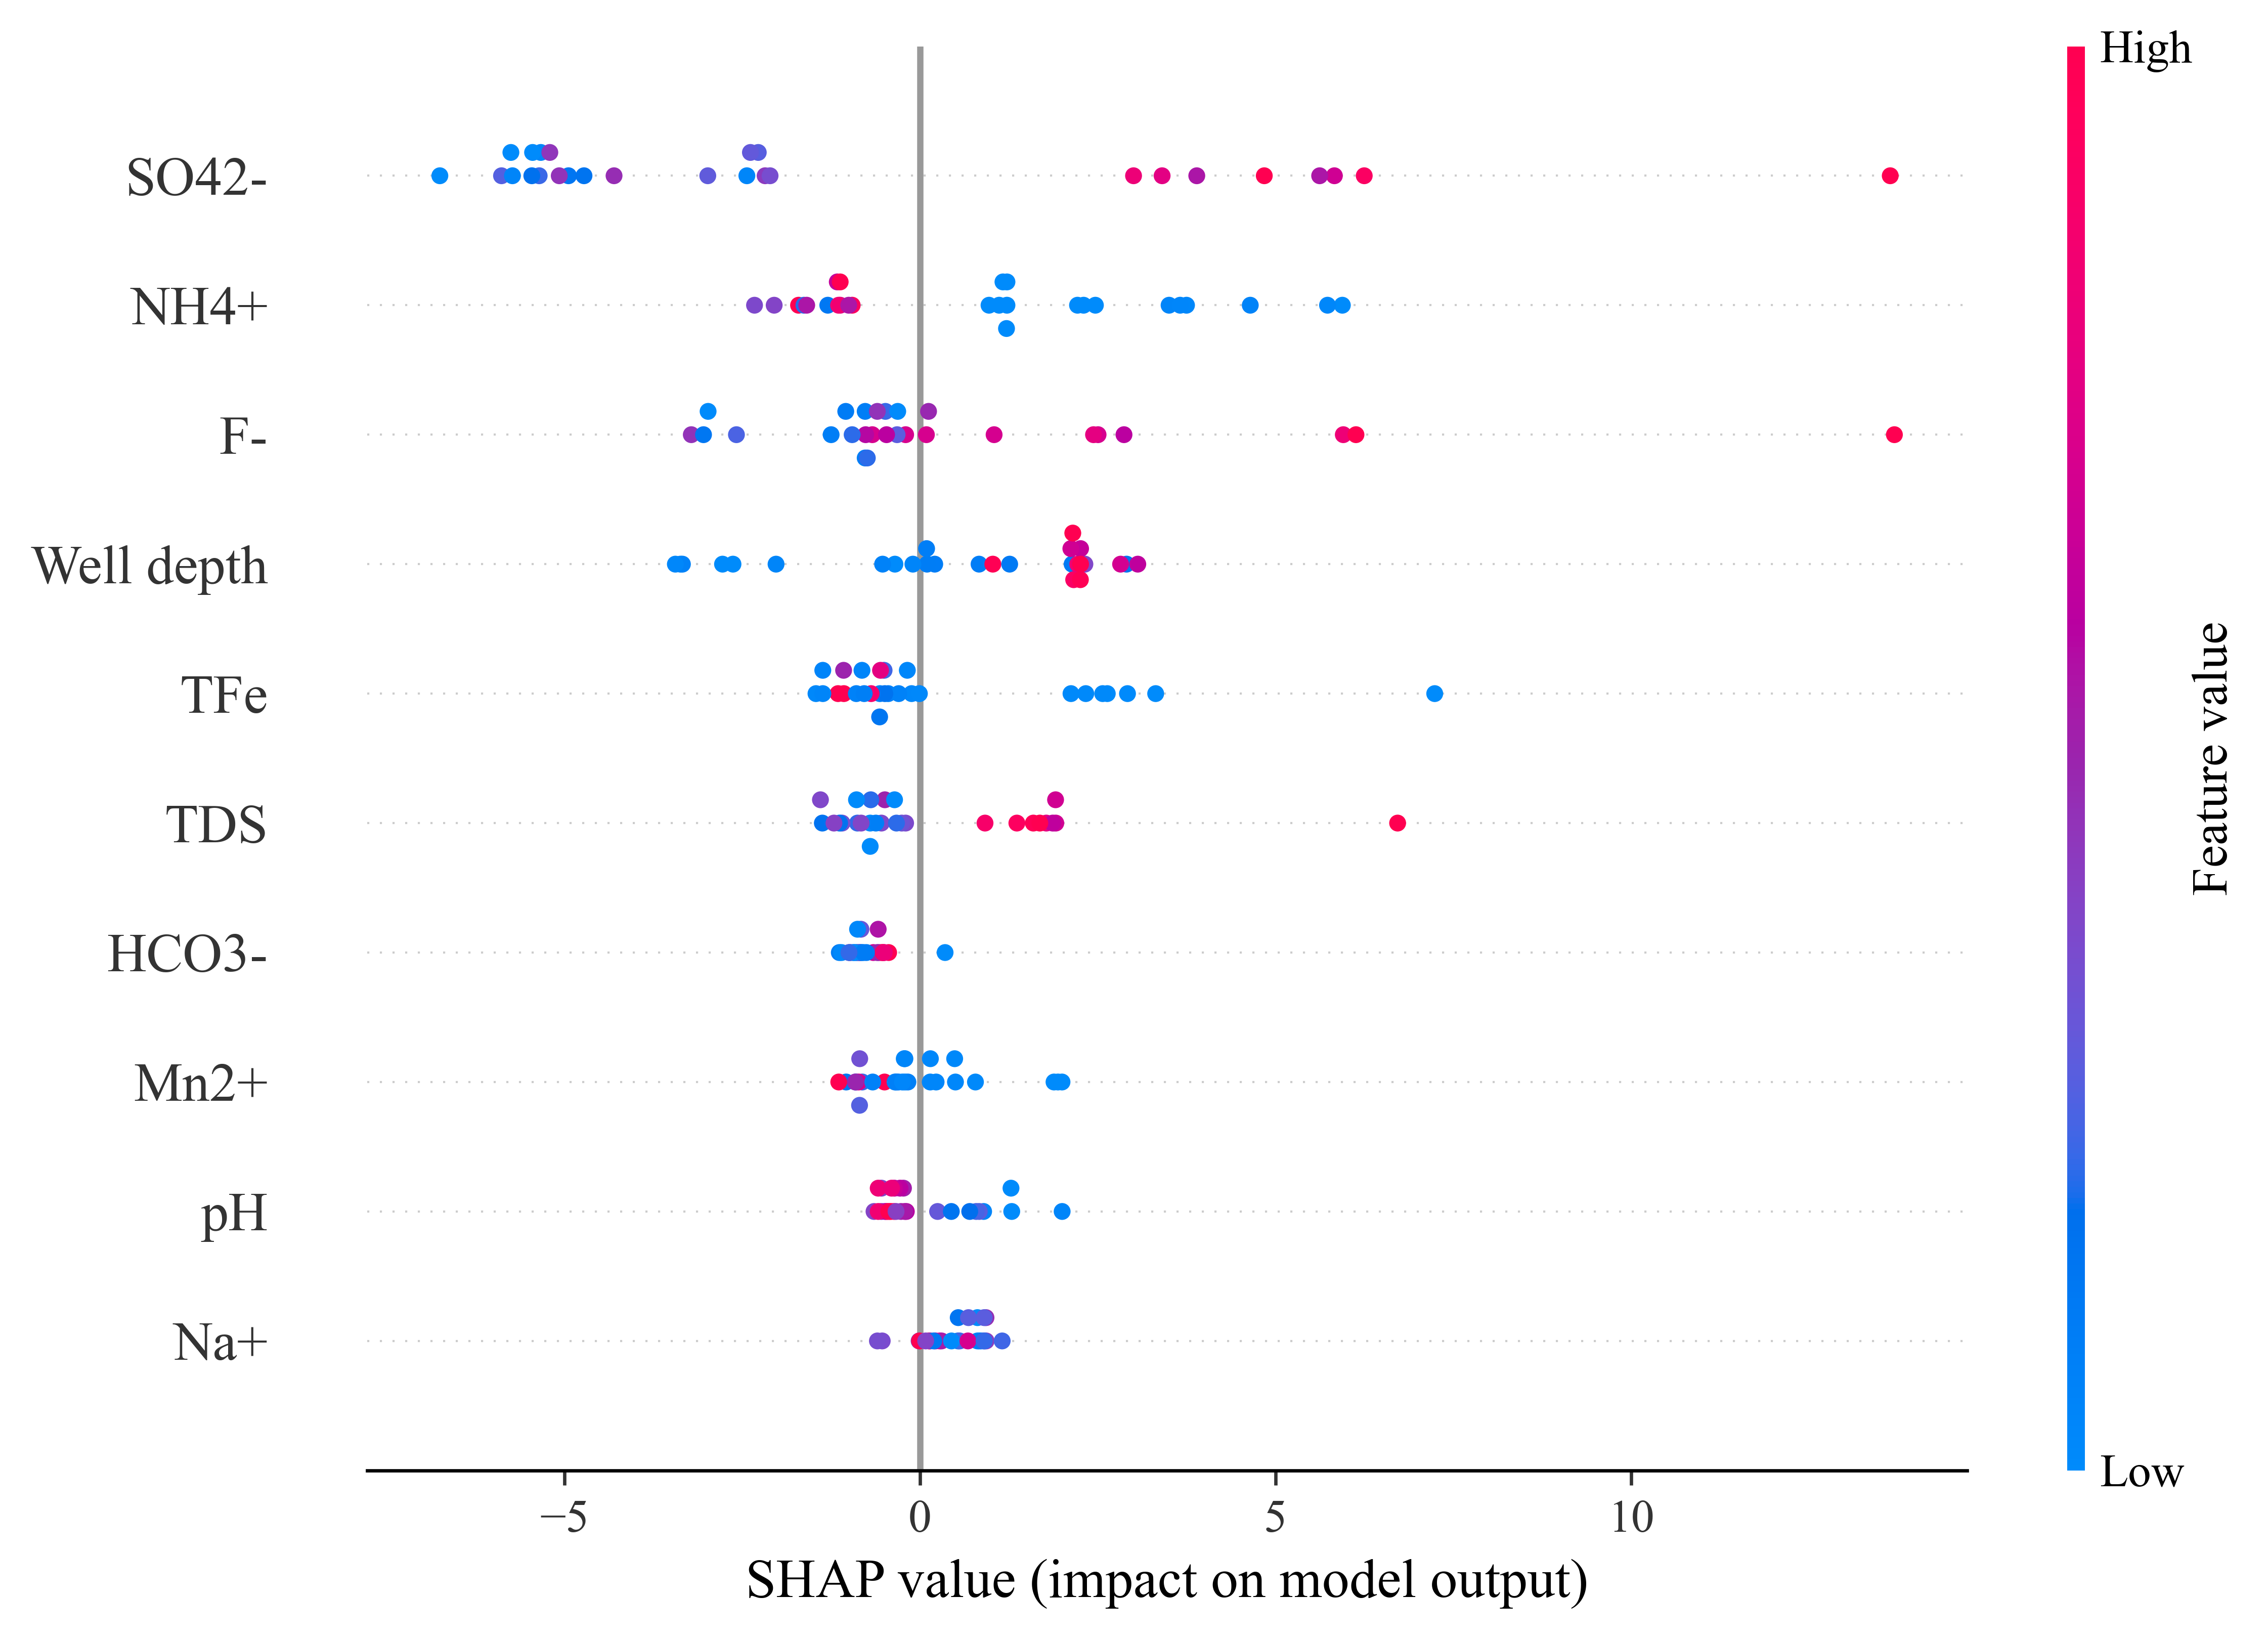

In [10]:
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_importance)

# Plot top 15 features
shap.summary_plot(shap_values, X_importance, max_display=10)

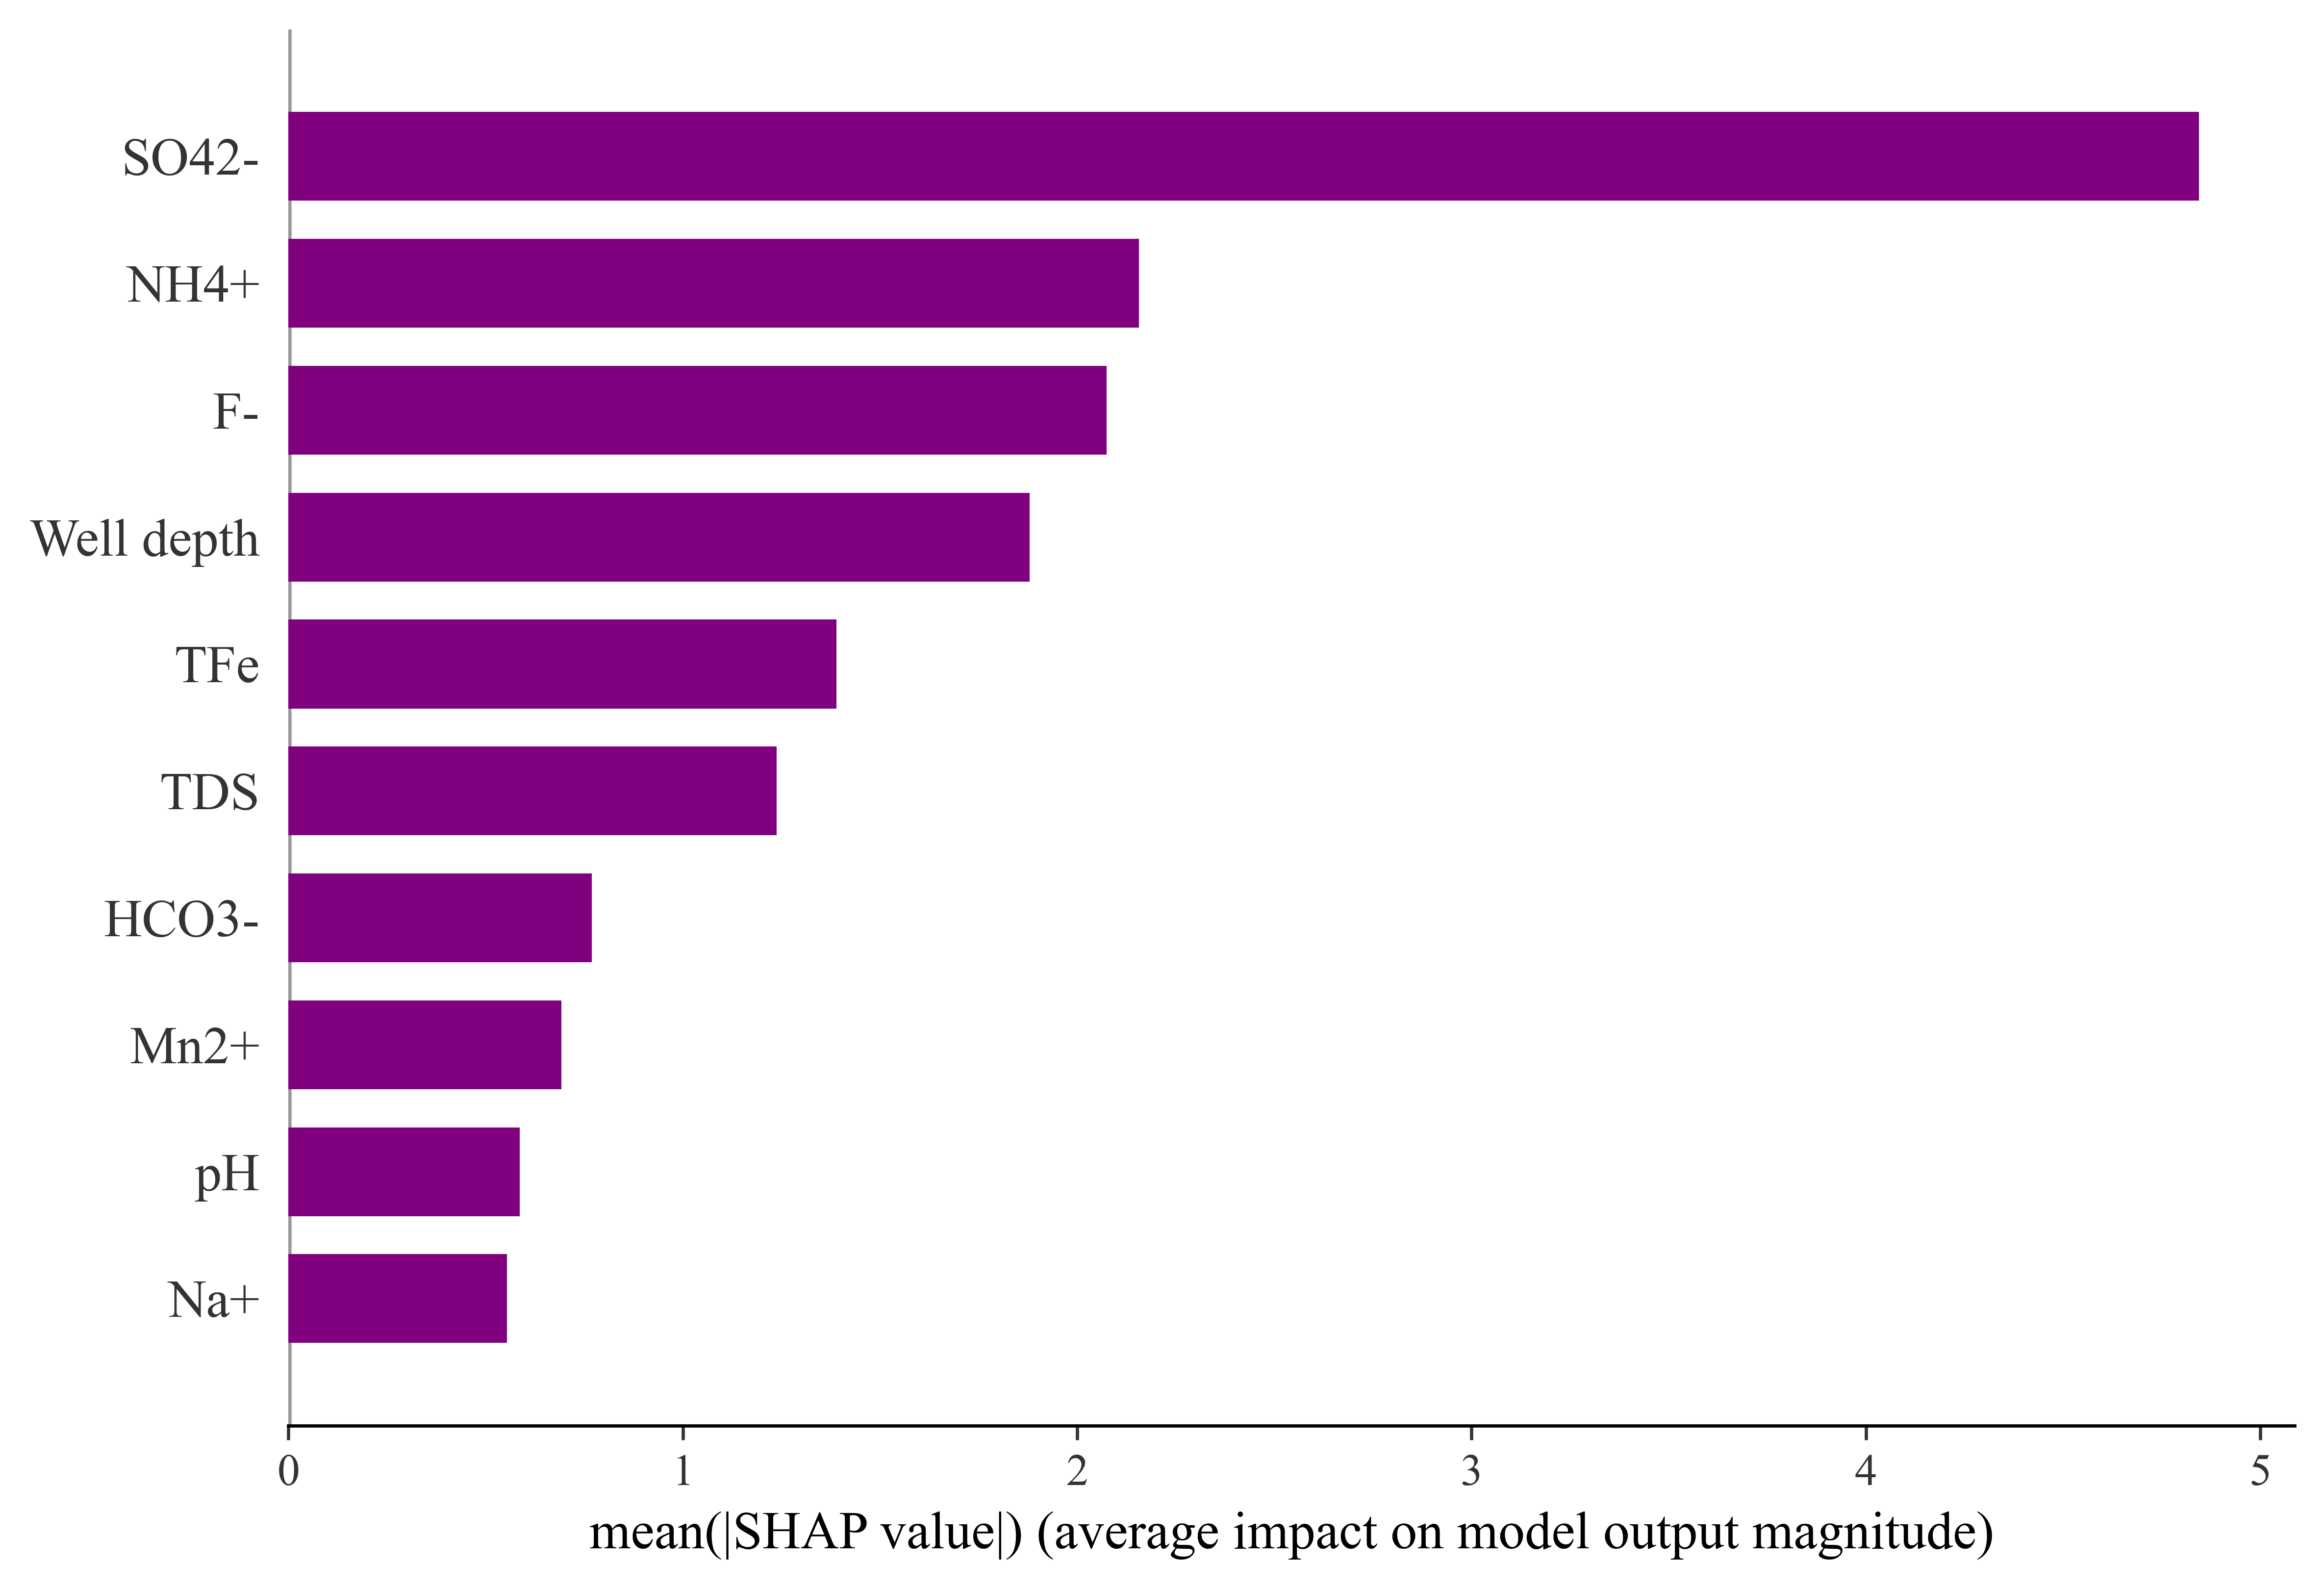

In [11]:
shap.summary_plot(shap_values, X_importance, plot_type='bar', max_display=10, color='purple')

/var/folders/7c/b7ckpd9x6vlbm8zzkdg8xbb4xjcxk_/T/ipykernel_15912/2192869860.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, label="Train", shade=True)
/Users/m089r172/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/7c/b7ckpd9x6vlbm8zzkdg8xbb4xjcxk_/T/ipykernel_15912/2192869860.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label="Test", shade=True)
/Users/m089r172/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be remov

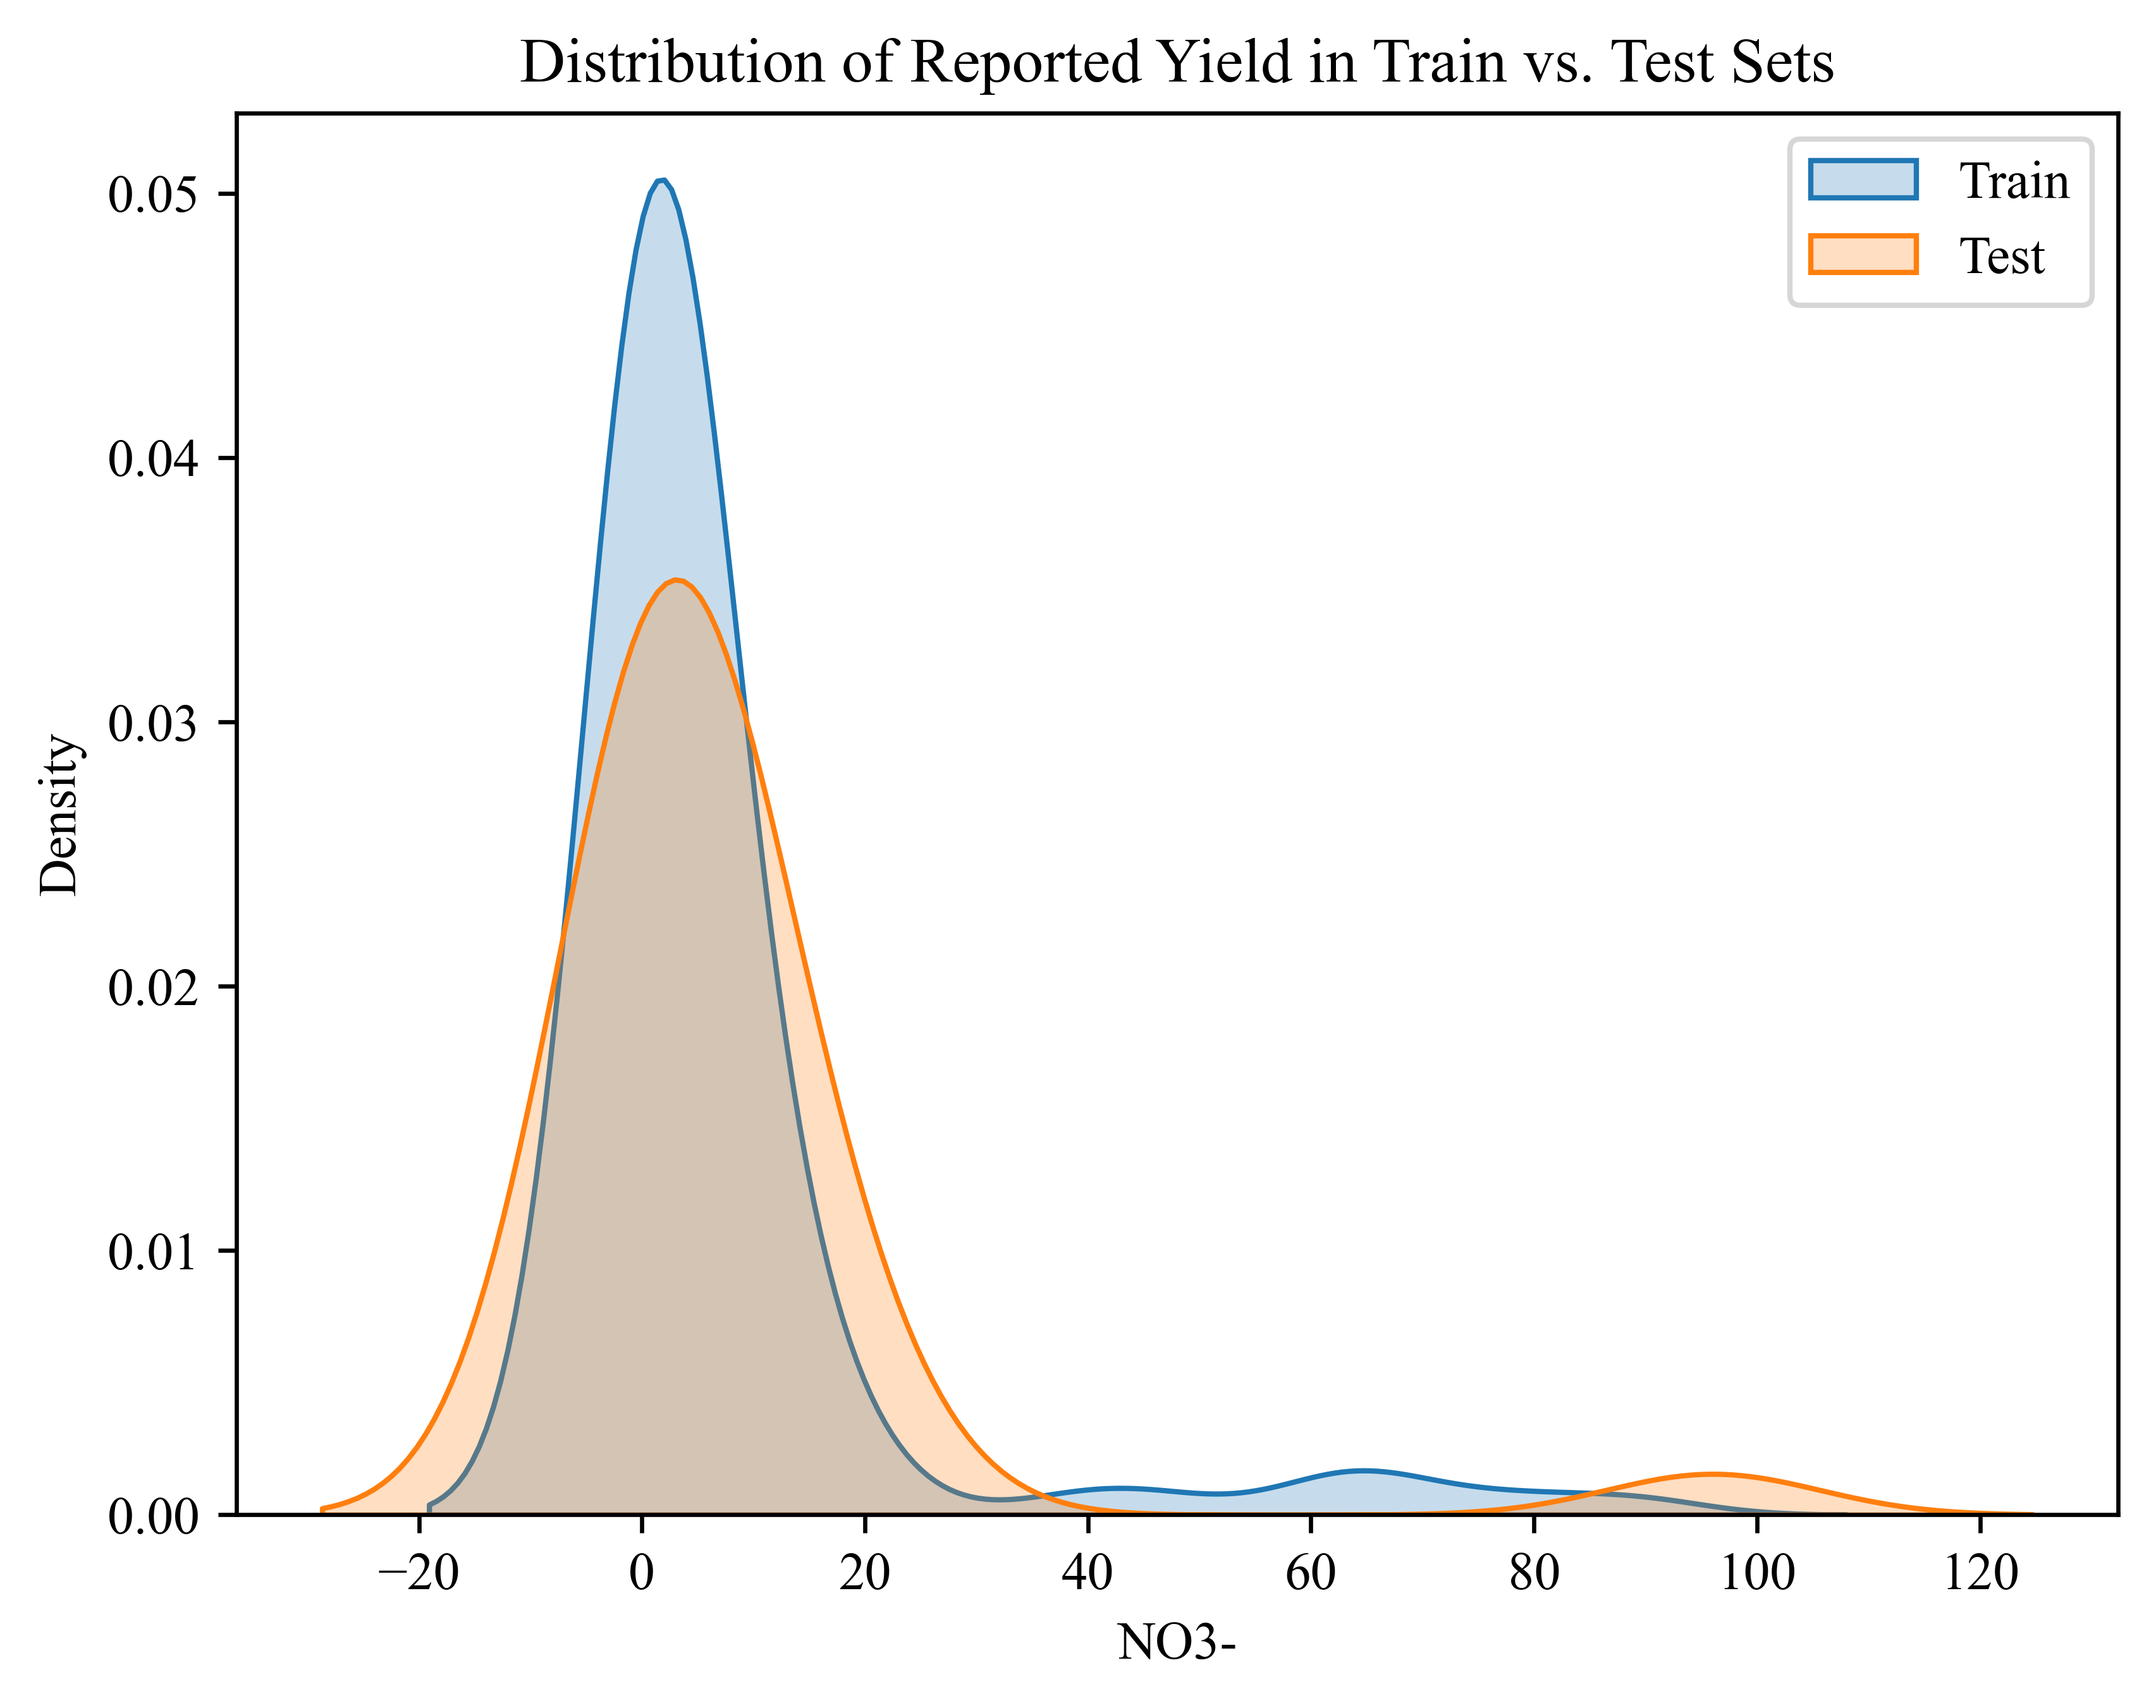

In [12]:
sns.kdeplot(y_train, label="Train", shade=True)
sns.kdeplot(y_test, label="Test", shade=True)
plt.legend()
plt.title("Distribution of Reported Yield in Train vs. Test Sets")
plt.show()

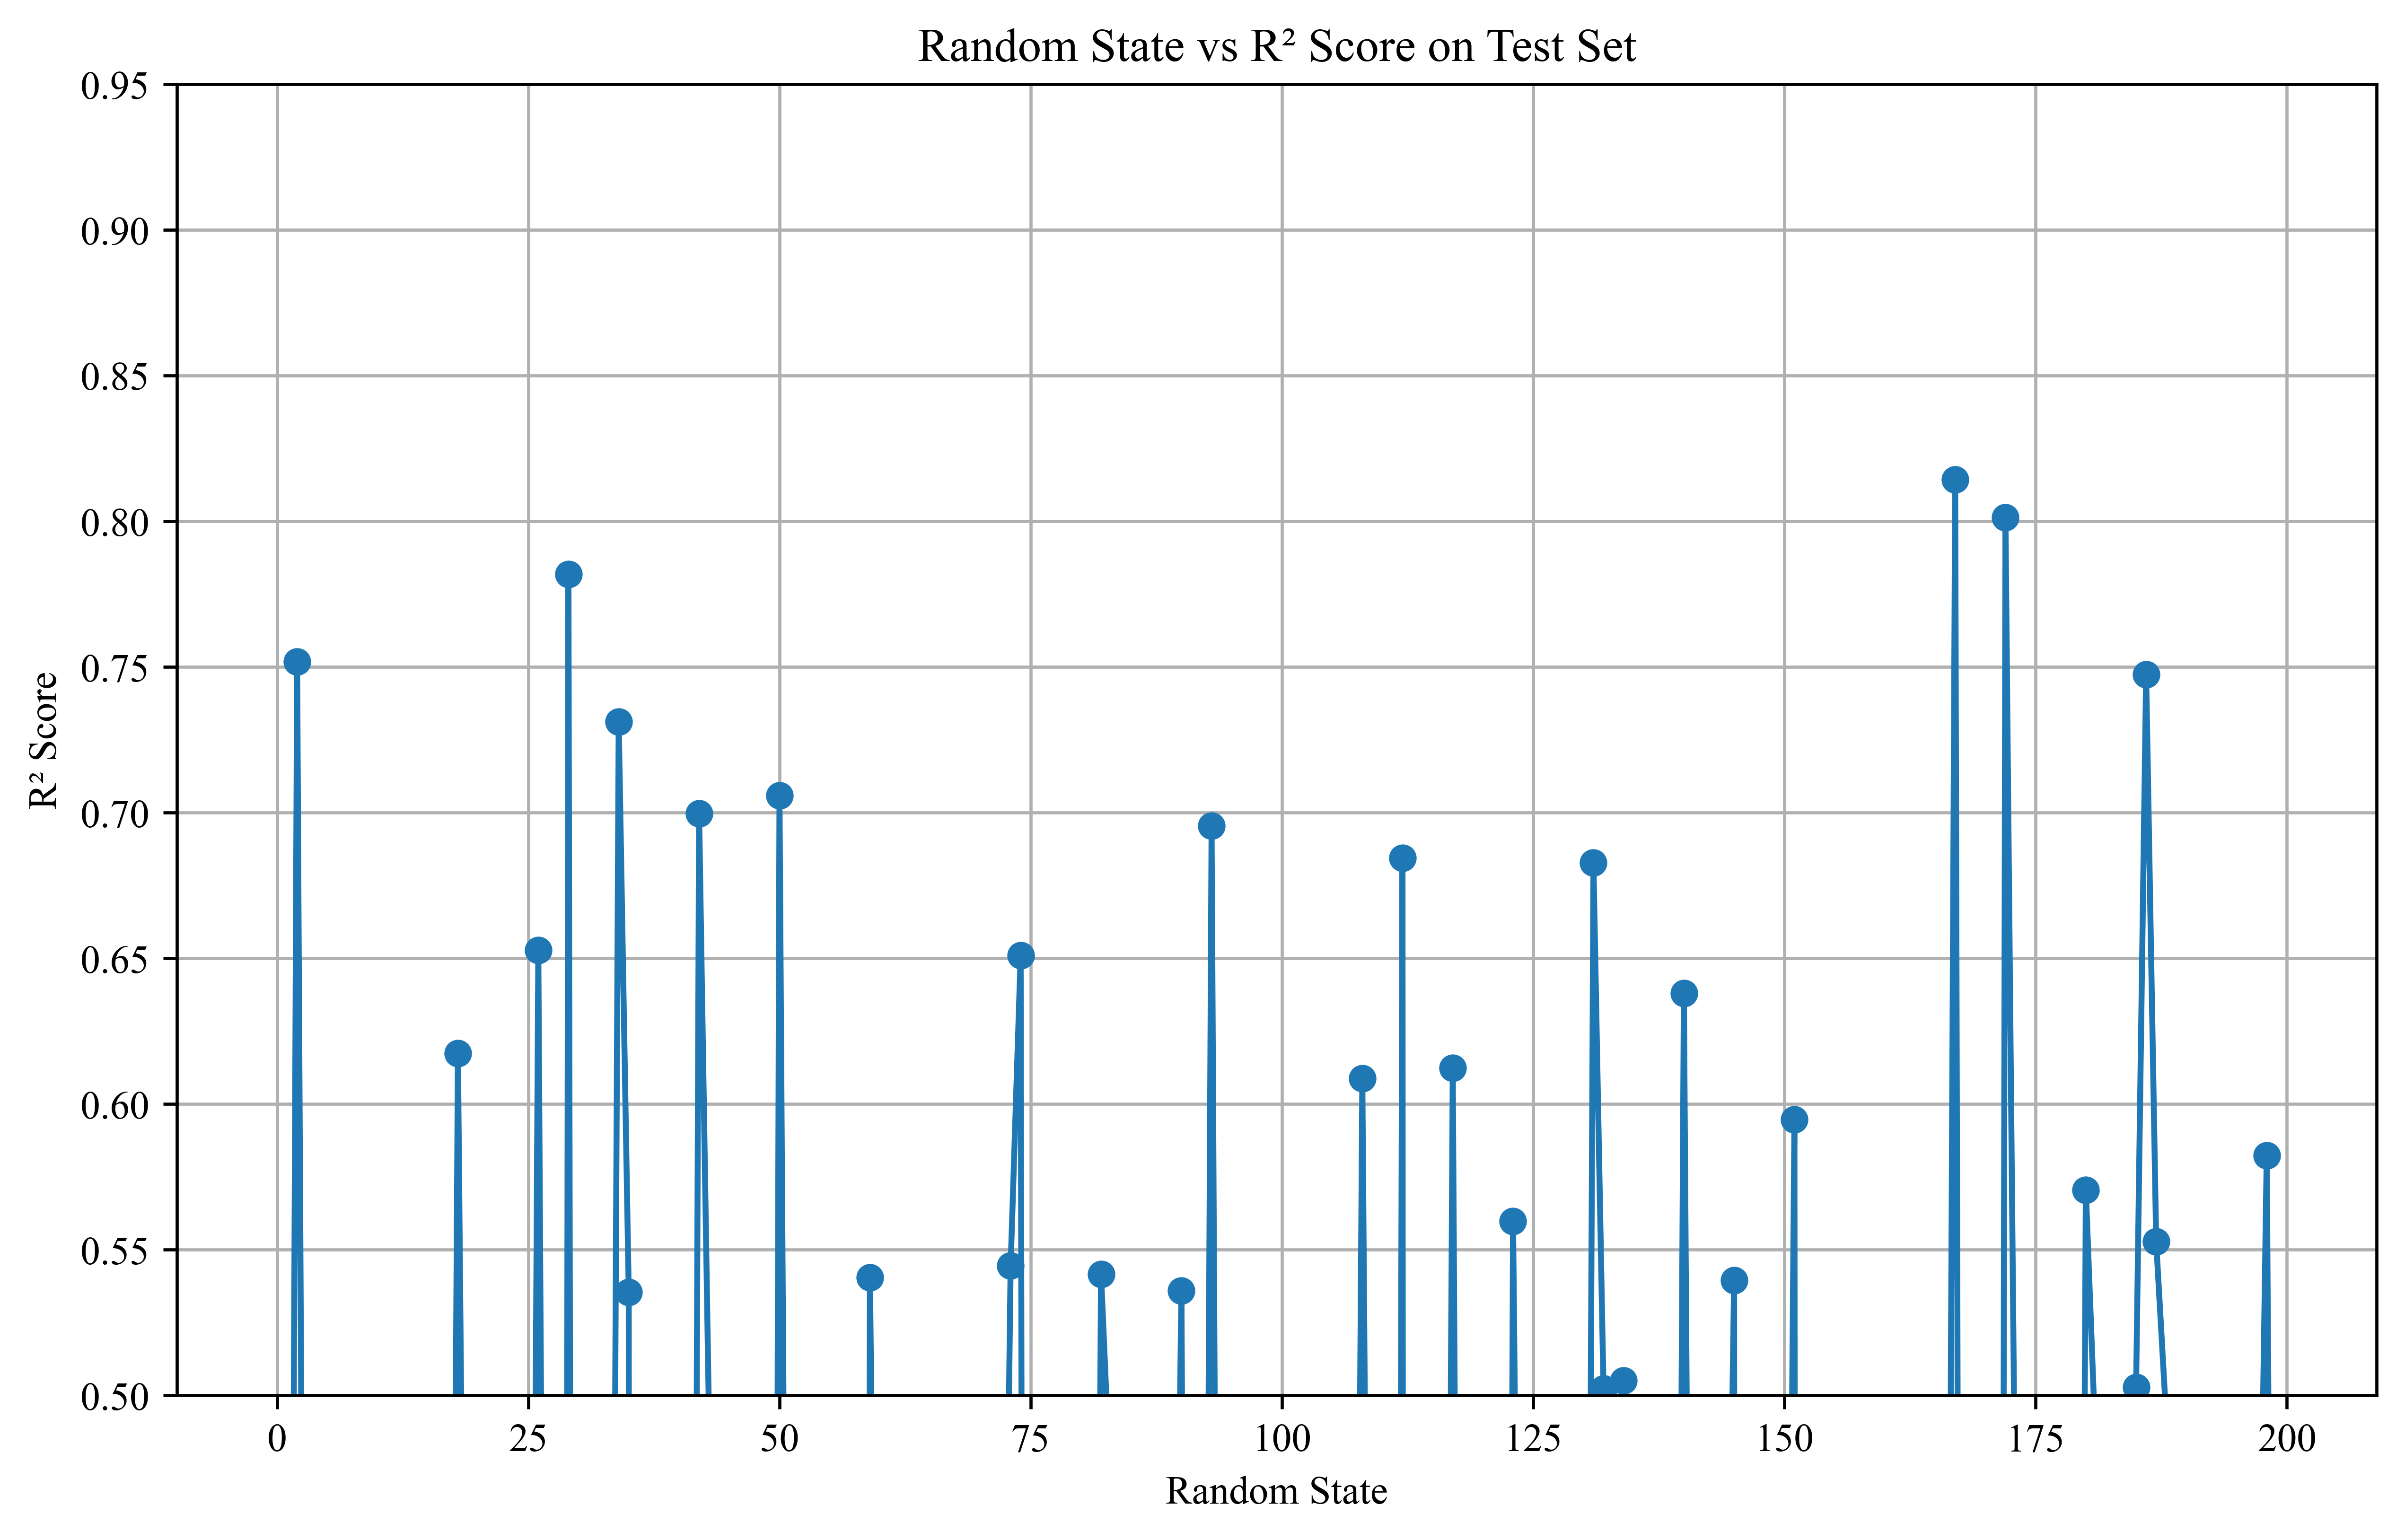

In [13]:
xgb_regressor = xgb.XGBRegressor()

# Hyperparameters
param_grid = {
    'n_estimators': [ 50],
    'max_depth': [ 3],
    'learning_rate': [ .1],
    'subsample': [.8],
    'colsample_bytree': [ .9],
    'gamma': [.6],
    "reg_alpha": [.5]
}

# Empty lists to store random_state and corresponding R2
random_states = []
r2_scores = []

# Loop over 100 random states
for random_state in range(0, 200):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Grid search
    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring=mae_scorer, cv=5, n_jobs=8)
    grid_search.fit(X_train, y_train)
    
    best_params_xgb = grid_search.best_params_
    
    # Train best model
    best_yld_xgb_model = xgb.XGBRegressor(**best_params_xgb)
    best_yld_xgb_model.fit(X_train, y_train)
    
    # Predict and calculate R2 on test set
    y_pred_xgb = best_yld_xgb_model.predict(X_test)
    r2_test_xgb = r2_score(y_test, y_pred_xgb)
    mae_test_xgb = mean_absolute_error(y_test, y_pred_xgb)
    
    # Store results
    random_states.append(random_state)
    r2_scores.append(r2_test_xgb)

# Plotting Random State vs R2
plt.figure(figsize=(10, 6))
plt.plot(random_states, r2_scores, marker='o')
plt.xlabel('Random State')
plt.ylim(.5,.95)
plt.ylabel('R² Score')
plt.title('Random State vs R² Score on Test Set')
plt.grid(True)

plt.show()


In [14]:
import numpy as np

# Convert to numpy array (if not already)
r2_scores_array = np.array(r2_scores)

# Get indices of top 5 highest R2 scores
top5_indices = np.argsort(r2_scores_array)[-5:][::-1]  # sort, pick last 5, then reverse

# Get the corresponding random states and R2 values
top5_random_states = [random_states[i] for i in top5_indices]
top5_r2_scores = [r2_scores[i] for i in top5_indices]

# Print them
for rs, r2 in zip(top5_random_states, top5_r2_scores):
    print(f'Random State: {rs}, R² Score: {r2:.4f}')

Random State: 167, R² Score: 0.8143
Random State: 172, R² Score: 0.8014
Random State: 29, R² Score: 0.7818
Random State: 2, R² Score: 0.7518
Random State: 186, R² Score: 0.7475


## benchmark

In [15]:

df["NO3- mean"] = df["NO3-"].mean()
df["NH4+ mean"] = df["NH4+"].mean()


In [16]:
X_xgb = df.iloc[:, 2:]  # assuming features start from column index 2
Y_xgb = df["NO3-"]

results_df, metrics_df = run_xgb_kfold(X_xgb, Y_xgb)
results_df

NameError: name 'run_xgb_kfold' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# PBIAS
def pbias(predicted, observed):
    return 100.0 * np.sum(observed - predicted) / np.sum(observed)

# Normalized MAE
def nmae(predicted, observed):
    return 100.0 * mean_absolute_error(observed, predicted) / np.mean(observed)

# Wrapper to calculate all metrics
def calc_metrics(predicted, observed):
    return {
        "PBIAS": pbias(predicted, observed),
        "NMAE": nmae(predicted, observed),
        "RMSE": np.sqrt(mean_squared_error(observed, predicted)),
        "R2": r2_score(observed, predicted)
    }



In [ ]:
# yield_df = ydff[["Reported_Yield", "yld_mean"]].dropna()
observed_yield = df["NO3-"].values
baseline_yield =df["NO3- mean"].values

yield_metrics = calc_metrics(baseline_yield, observed_yield)
yield_metrics

In [ ]:
# yield_df = ydff[["Reported_Yield", "yld_mean"]].dropna()
observed_yield = df["NH4+"].values
baseline_yield =df["NH4+ mean"].values

yield_metrics = calc_metrics(baseline_yield, observed_yield)
yield_metrics

## NH4 model

In [17]:
y = df['NH4+']
X = df.drop(columns=['NH4+', 'Year'])


# Step 2: Split by year
# X_train = X[years.isin([2017, 2018])]
# y_train = y[years.isin([2017, 2018])]
# X_test = X[years == 2020]
# y_test = y[years == 2020]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=137)

X_train

NO3-    pH      TDS    Ca2+    Mg2+     K+     Na+   Mn2+     TFe  \
106   0.39  8.13   465.00   44.55   32.94   1.48   69.32  0.007   0.031   
93    2.08  7.17  3762.00  304.40  209.90   7.54  653.30  2.090  12.270   
0    10.17  7.59   879.20   84.08   60.70  22.00  122.80  0.008   0.110   
102   0.01  7.74  1095.00  169.00   63.75   4.09  126.20  1.041   3.900   
91    0.00  7.60   301.52   42.42   28.06   2.00   26.00  0.128   0.070   
..     ...   ...      ...     ...     ...    ...     ...    ...     ...   
129   1.85  7.56  1042.00   62.92   95.23   5.64  154.80  0.001   1.917   
78    3.16  7.57   697.88  106.04   57.28   3.00   54.80  0.052   0.110   
75    0.00  7.65   795.92   84.83   60.79   2.00  114.00  0.171   0.430   
77    7.68  7.59  1501.65  150.38  109.89   5.50  192.00  0.035   0.080   
38    8.58  7.46  1031.83   90.09   97.12   4.00  145.20  0.352   0.180   

             Cl-    SO42-       HCO3-     CODMn        F-  Well depth  \
106    57.779881   112.70  250.862853  1.402062  1.008629       15.00   
93   1030.845609  1181.00  652.635391  3.381443  0.240240       10.00   
0     131.080000   261.53  328.250000  0.830000  0.600000       11.71   
102   202.229584   219.20  558.561821  3.298969  0.221330       21.00   
91     43.690000    16.35  248.100000  0.890000  0.800000      156.83   
..           ...      ...         ...       ...       ...         ...   
129   106.367509   315.60  550.722357  1.360825  1.943439       20.00   
78     77.300000   153.26  437.440000  1.220000  0.200000       23.42   
75    114.270000   148.32  496.200000  1.350000  0.100000      157.32   
77    315.930000   556.34  287.280000  1.770000  0.200000       23.42   
38    127.720000   259.37  577.720000  1.020000  0.700000        4.33   

     NO3- mean  NH4+ mean  
106   7.017164   0.556687  
93    7.017164   0.556687  
0     7.017164   0.556687  
102   7.017164   0.556687  
91    7.017164   0.556687  
..         ...        ...  
129   7.017164   0.556687  
78    7.017164   0.556687  
75    7.017164   0.556687  
77    7.017164   0.556687  
38    7.017164   0.556687  

[107 rows x 17 columns]

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'reg_alpha': 0.3, 'subsample': 0.7}

--- Training Performance ---
MAE: 0.2495
RMSE: 0.3485
R²: 0.8458

--- Test Performance ---
MAE: 0.3230
RMSE: 0.4252
R²: 0.8498


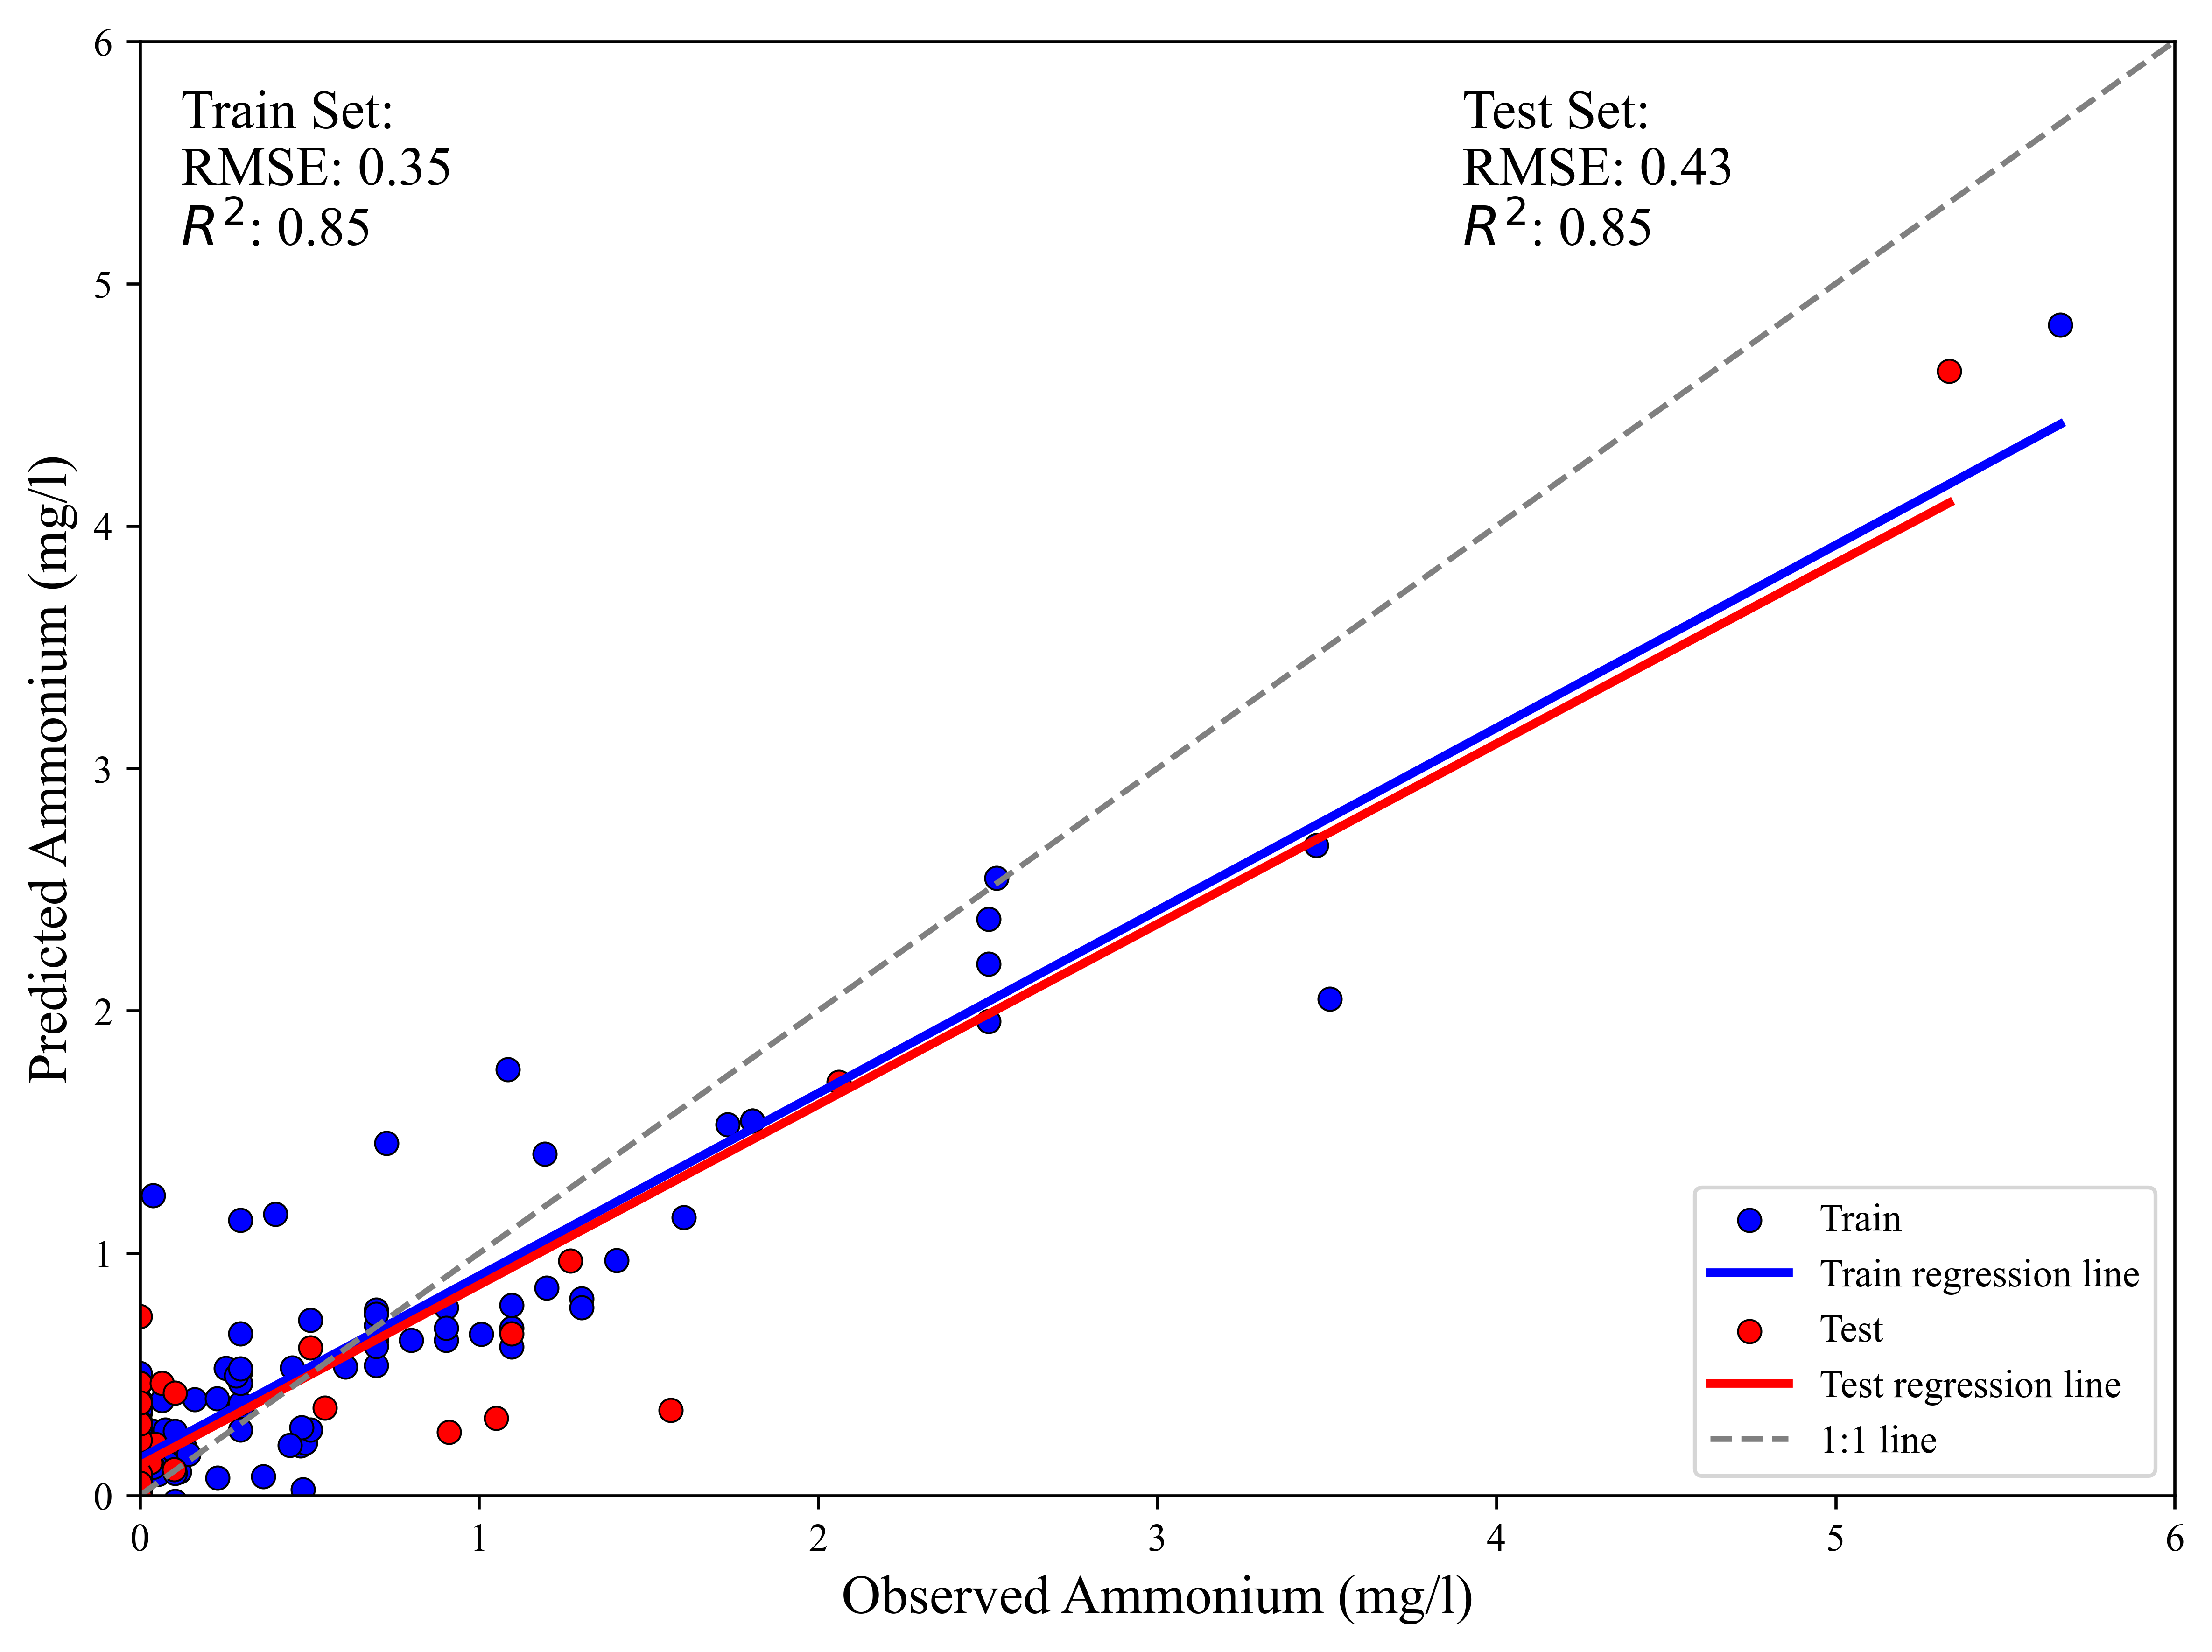

In [18]:


mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
xgb_regressor = xgb.XGBRegressor()

# 5. Define hyperparameter grid
# param_grid = {
#     'n_estimators': [ 50, 100, 500],
#     'max_depth': [2, 5,10],
#     'learning_rate': [0.1, 0.2],
#     'subsample': [ .7,.9,.8],
#     'colsample_bytree': [ .7,.8,.9],
#     'gamma': [.2, .3, .5, ],
#     "reg_alpha": [.3,.5,.6, .7]
# }

param_grid = {'colsample_bytree': [0.9],
            'subsample': [.7],
            'learning_rate': [0.1], 
            'max_depth': [2],
            'n_estimators': [50], 
            'reg_alpha': [0.3],
            'gamma': [ .5], 

         }

# 6. Perform grid search
grid_search = GridSearchCV(
    estimator=xgb_regressor,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=5,
    n_jobs=7,
    verbose=1
)
grid_search.fit(X_train, y_train)

# 7. Train final model with best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

best_model = xgb.XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

# 8. Predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# 9. Evaluation
def evaluate(y_true, y_pred, label=""):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- {label} Performance ---")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")

evaluate(y_train, y_pred_train, label="Training")
evaluate(y_test, y_pred_test, label="Test")

evaluate_model(
    y_train, y_pred_train , 
    y_test, y_pred_test, 
    xlabel='Observed Ammonium', ylabel='Predicted Ammonium', units='mg/l',
    xlim = (0,6), ylim =(0,6) 
    
)



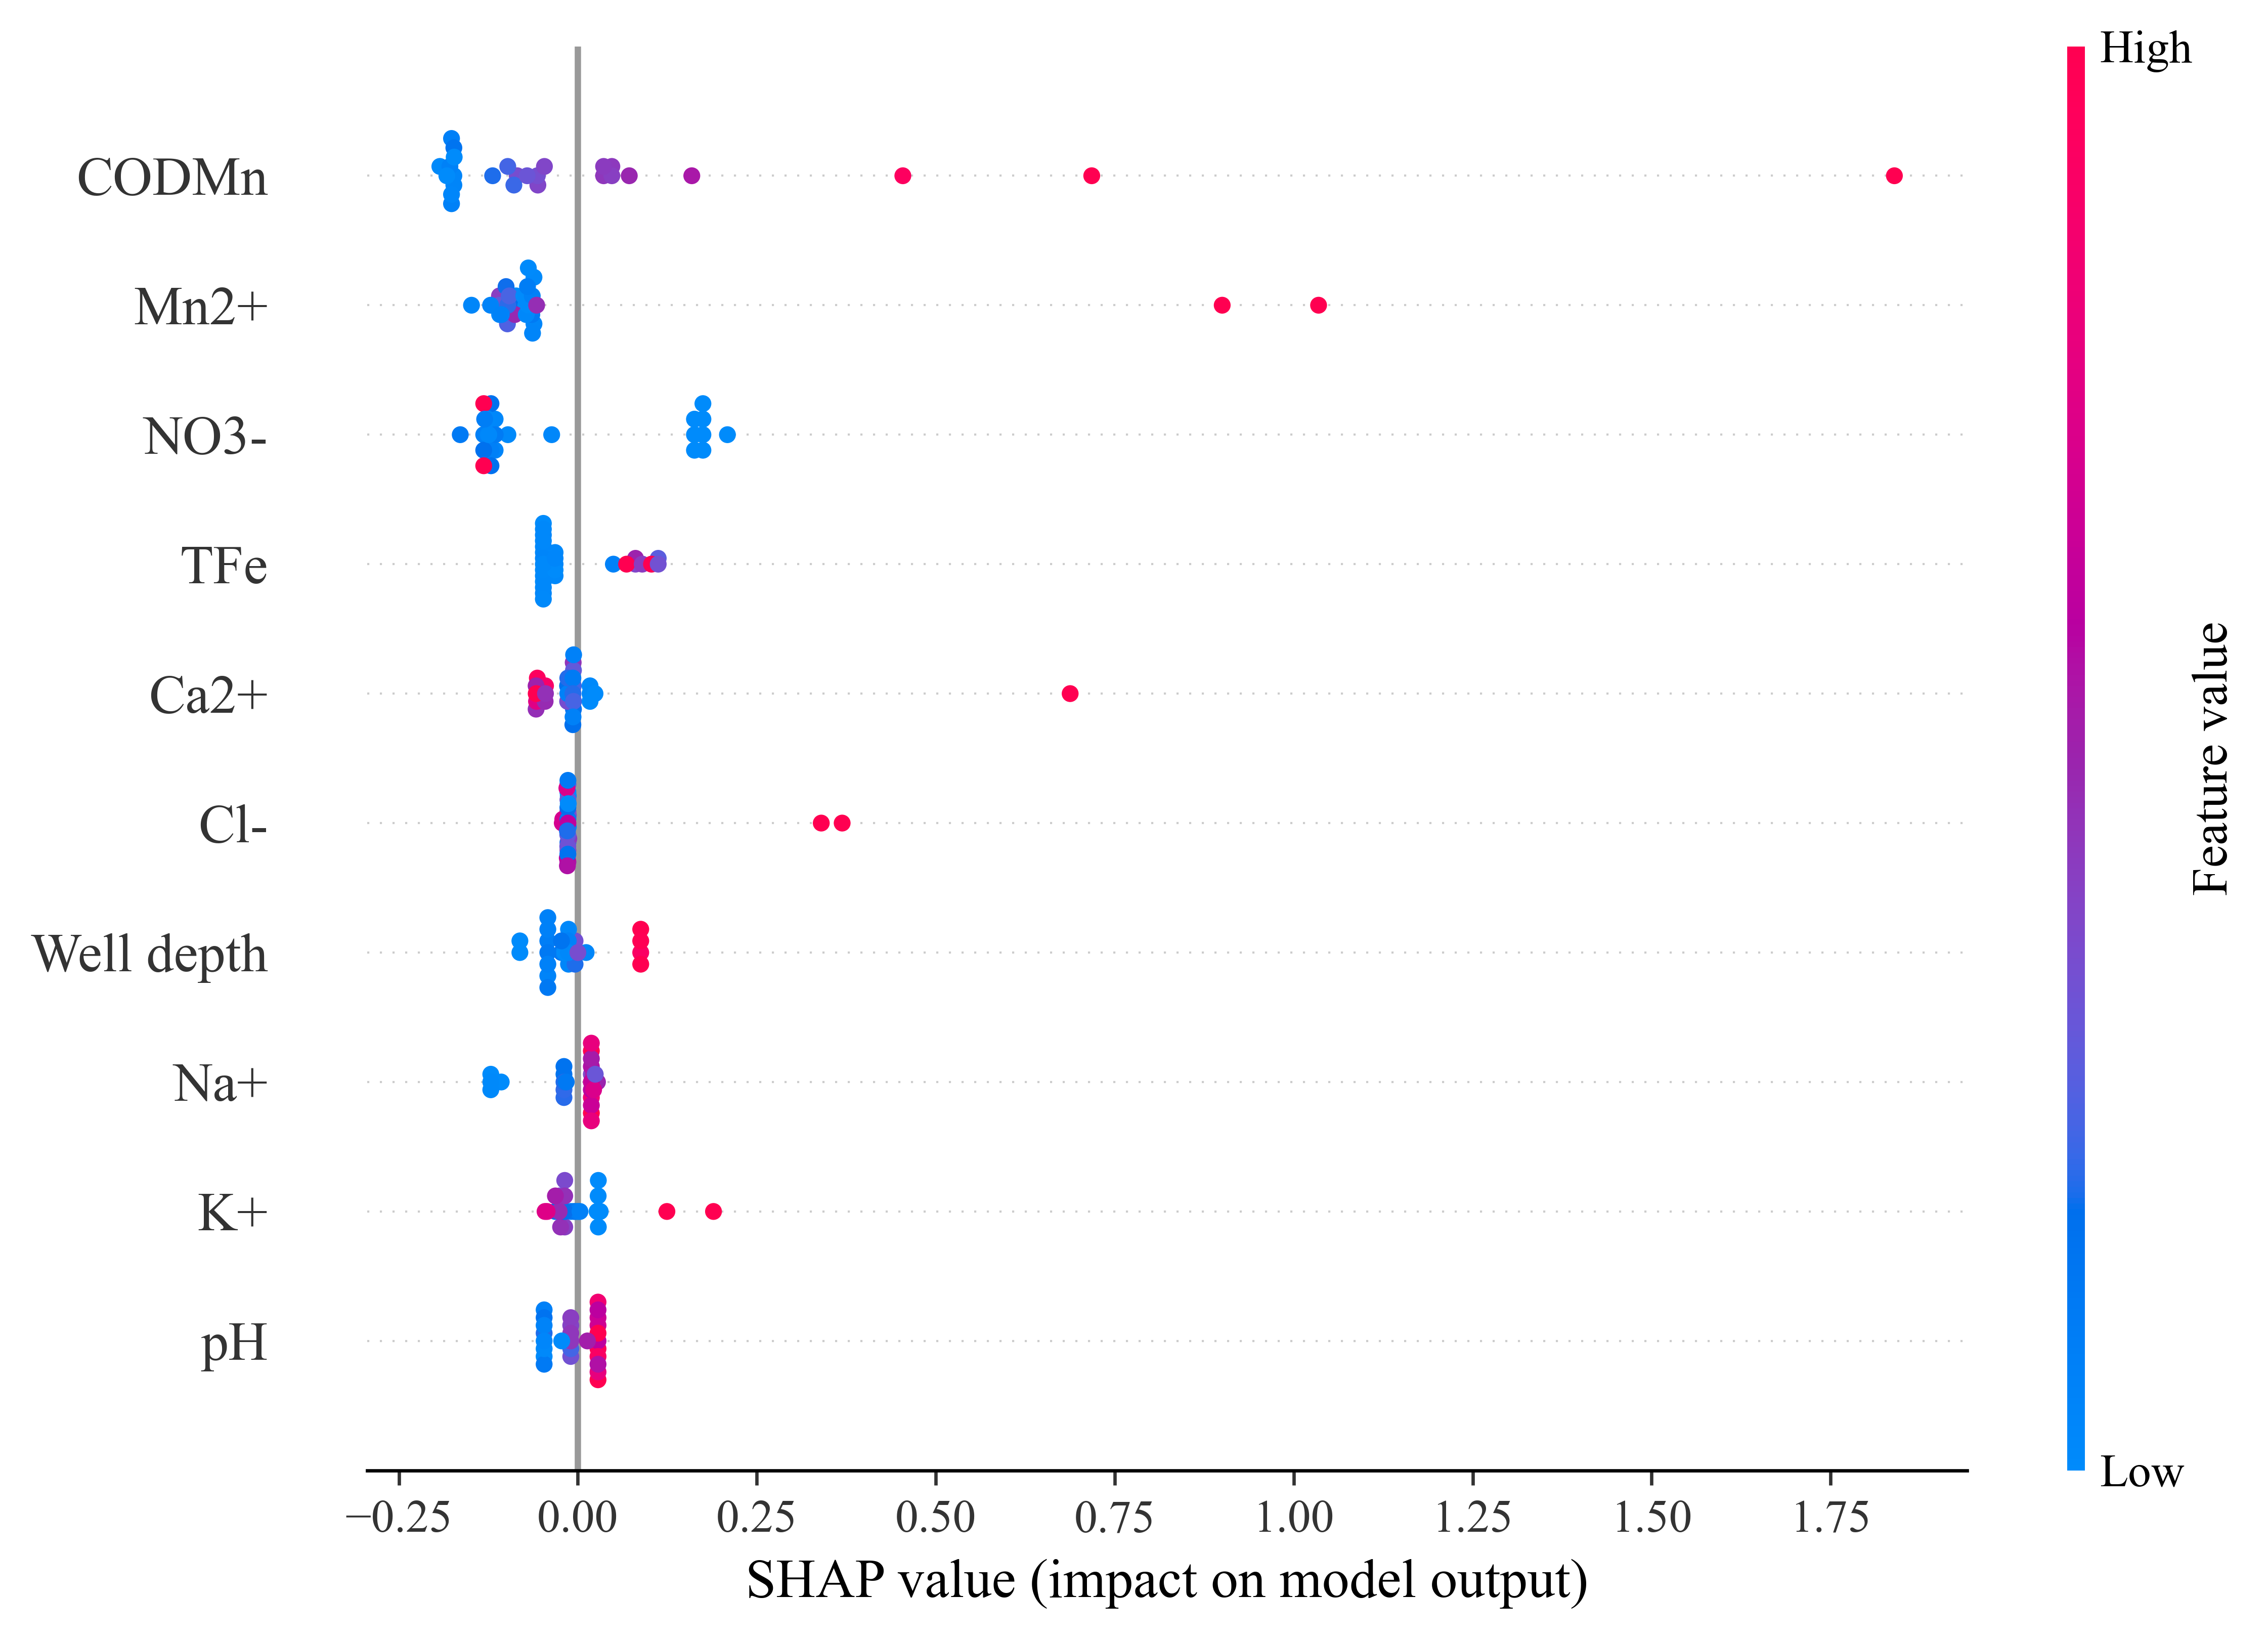

In [19]:
X_importance = X_test

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_importance)

# Plot top 15 features
shap.summary_plot(shap_values, X_importance, max_display=10)

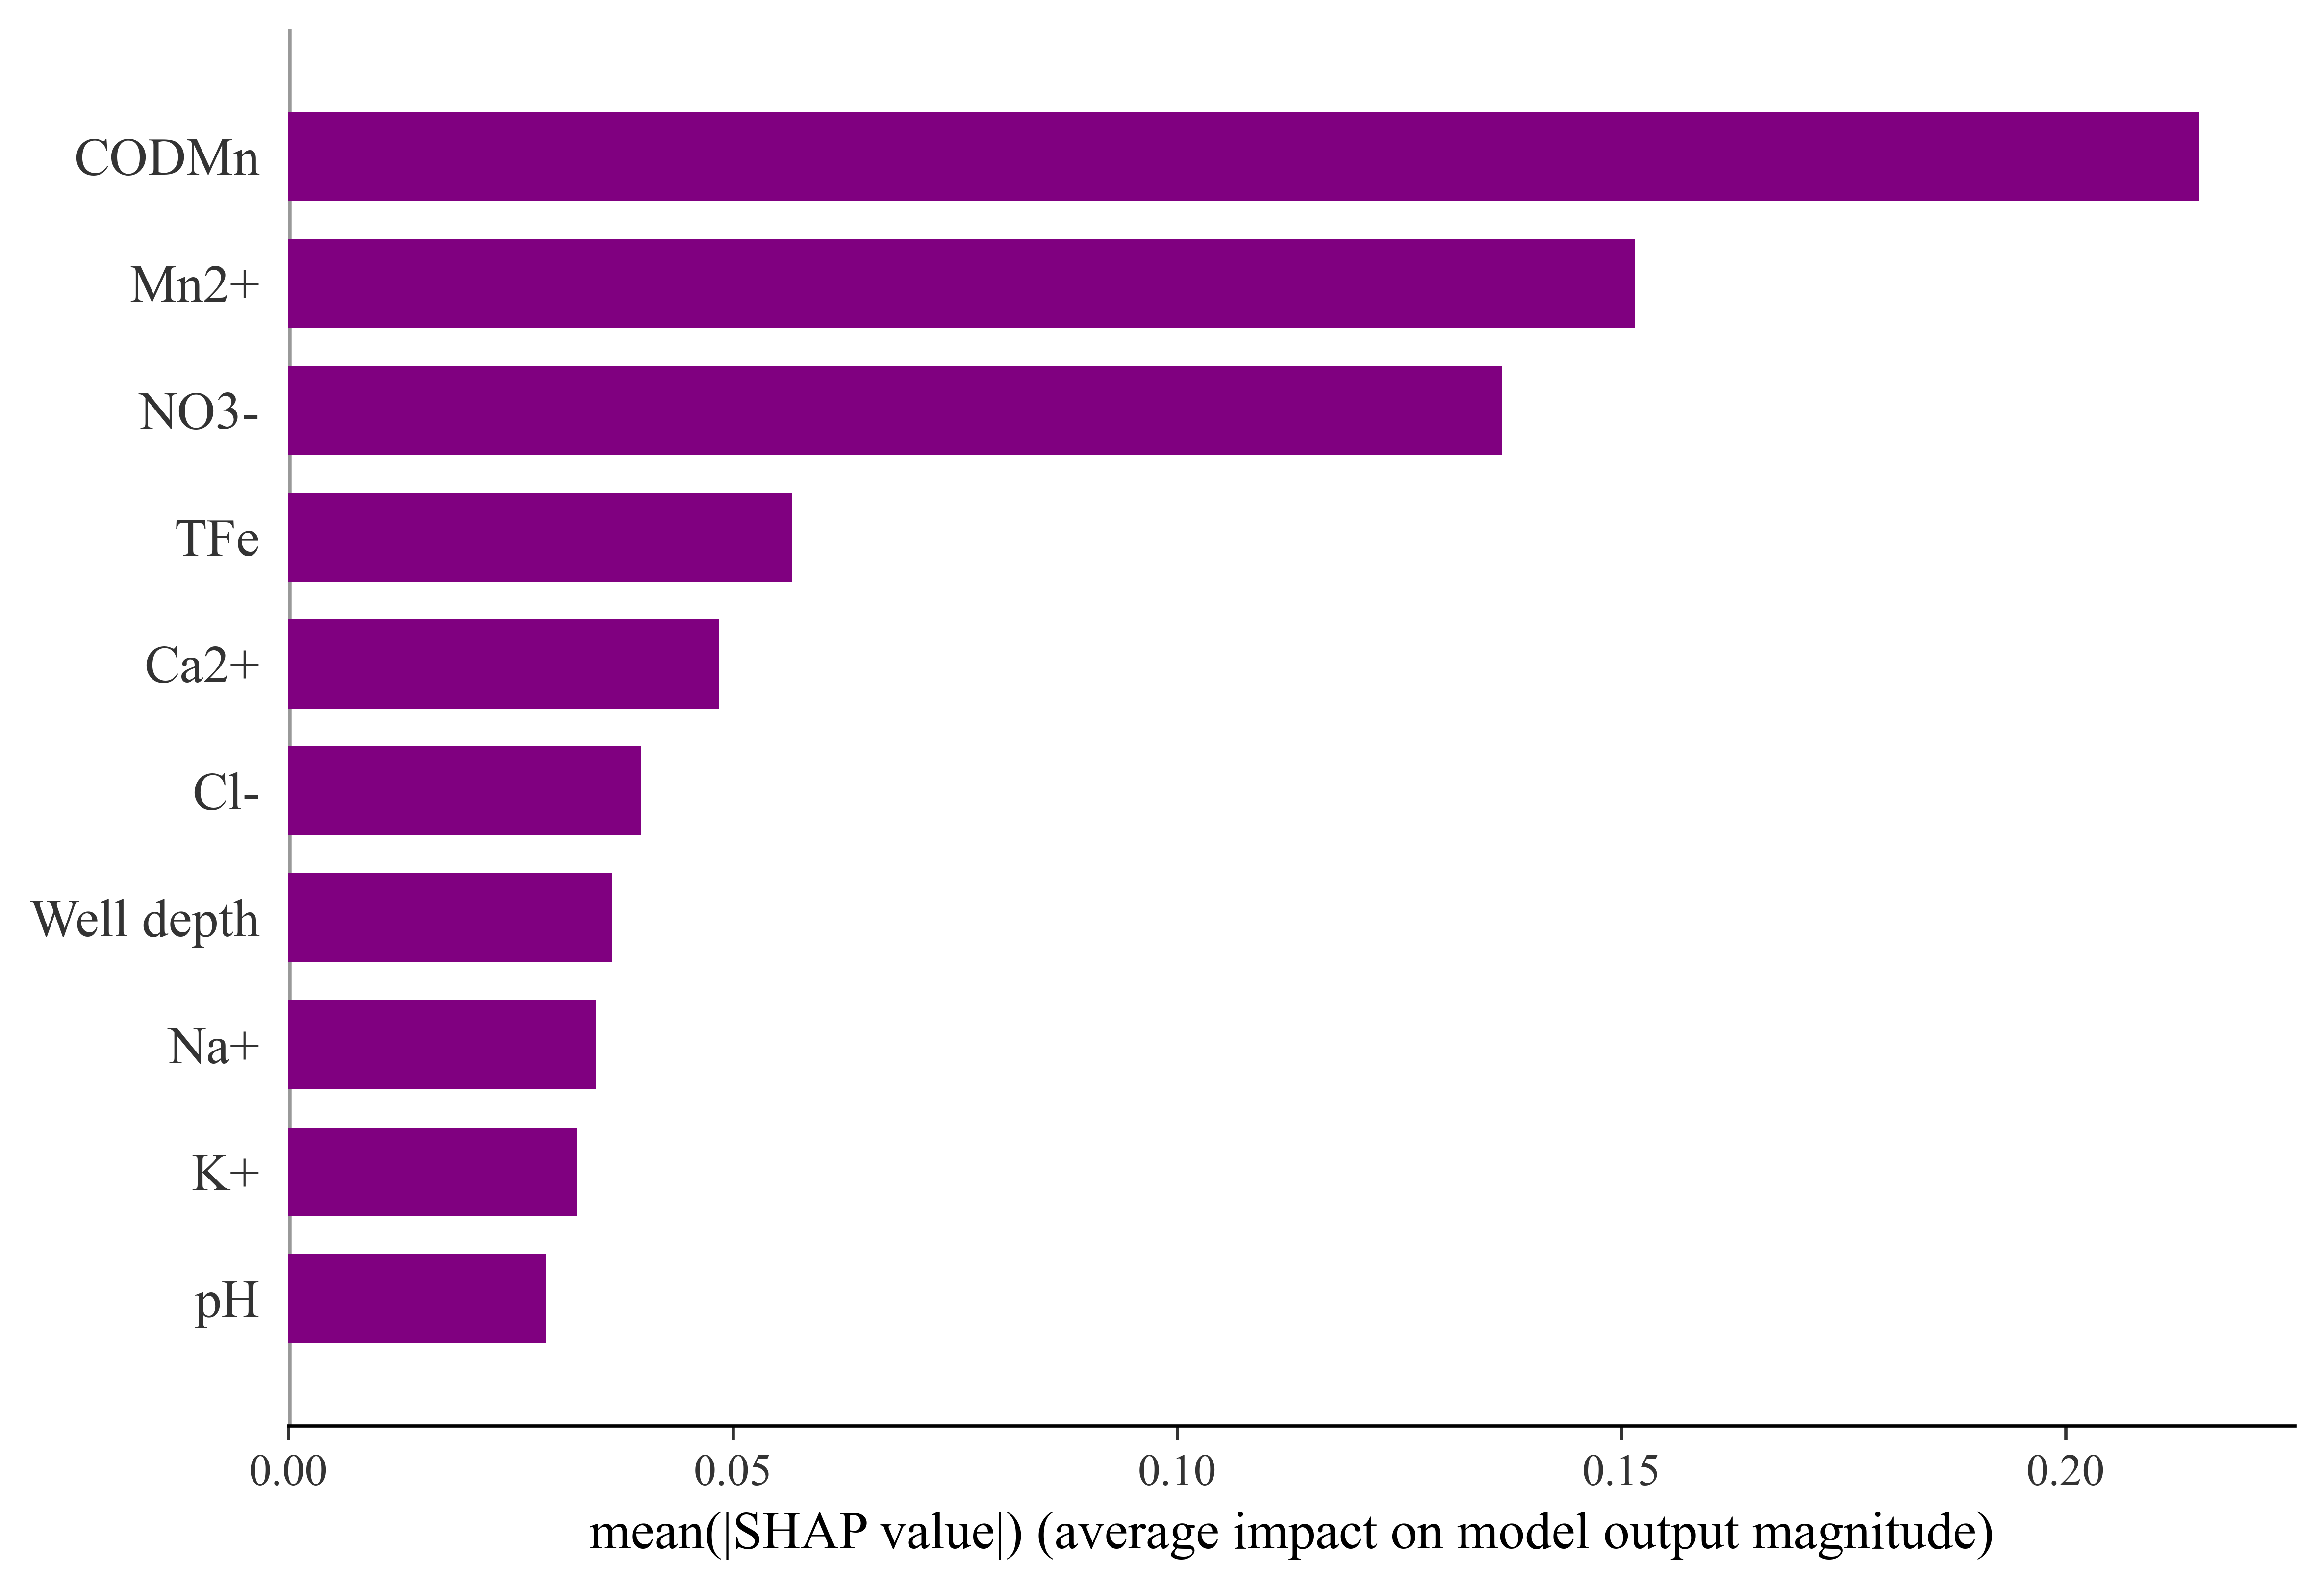

In [20]:
shap.summary_plot(shap_values, X_importance, plot_type='bar', max_display=10, color='purple')

/var/folders/7c/b7ckpd9x6vlbm8zzkdg8xbb4xjcxk_/T/ipykernel_15912/2192869860.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_train, label="Train", shade=True)
/Users/m089r172/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/7c/b7ckpd9x6vlbm8zzkdg8xbb4xjcxk_/T/ipykernel_15912/2192869860.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label="Test", shade=True)
/Users/m089r172/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be remov

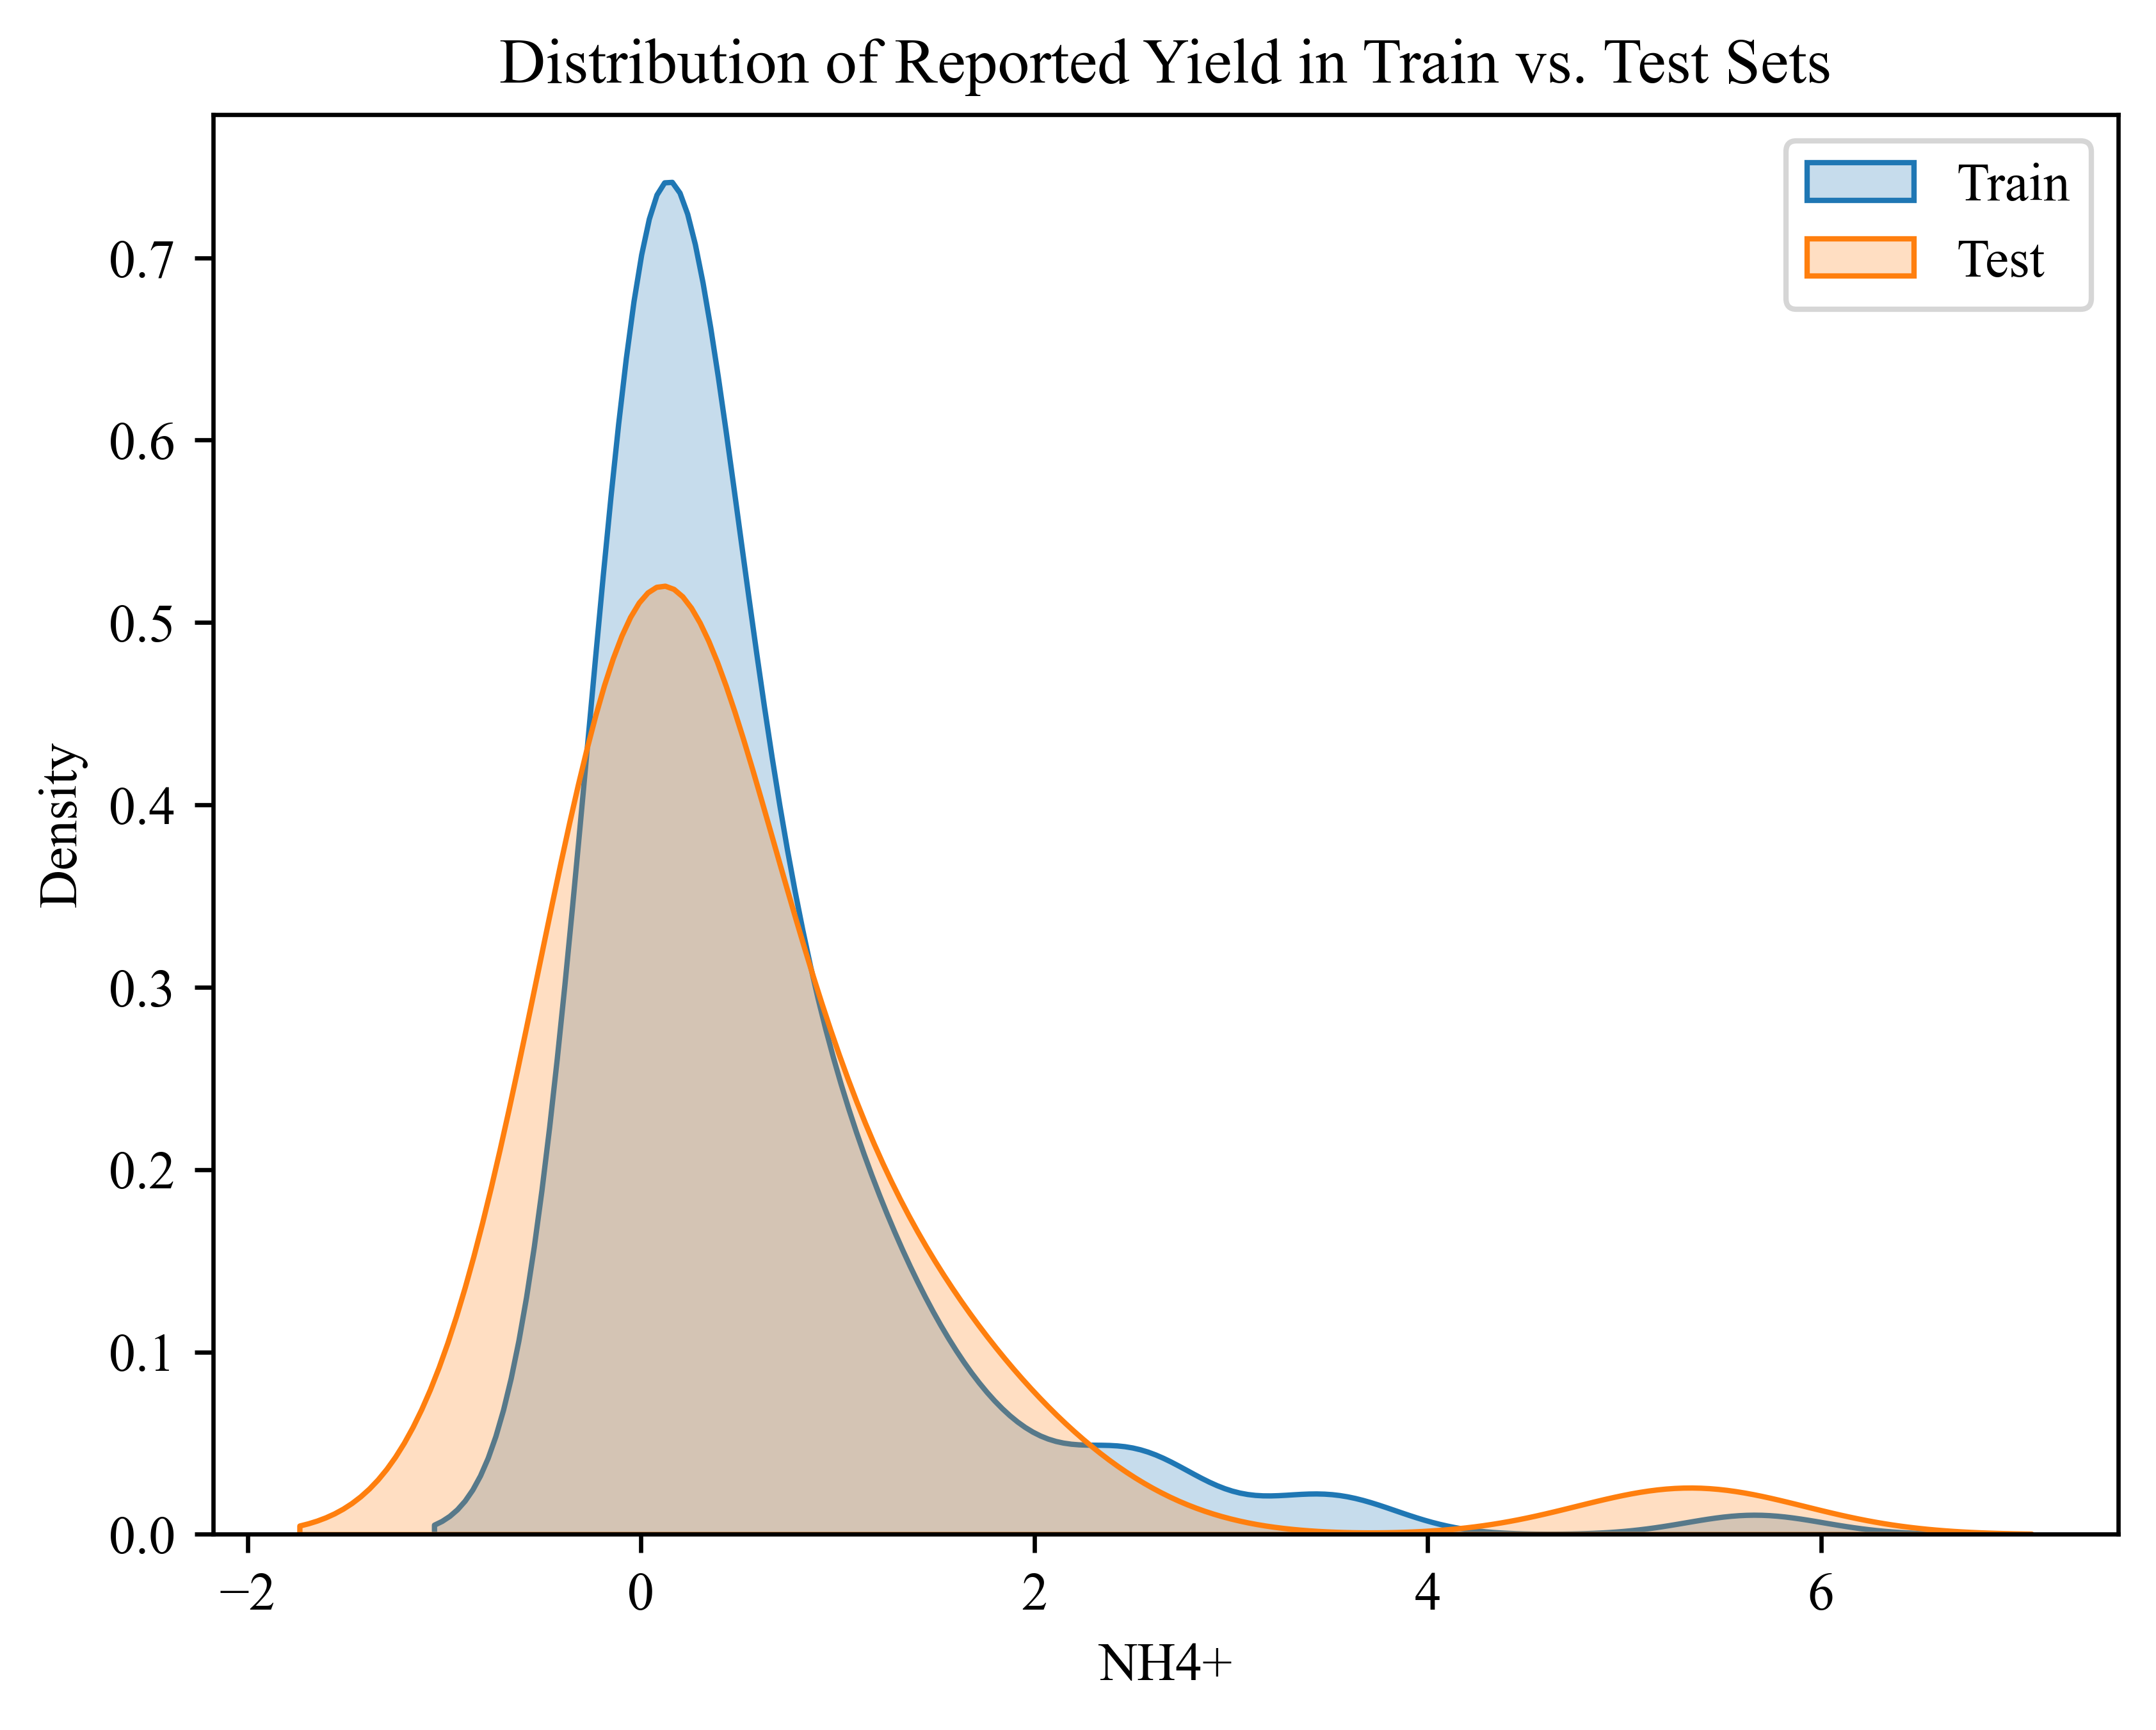

In [21]:
sns.kdeplot(y_train, label="Train", shade=True)
sns.kdeplot(y_test, label="Test", shade=True)
plt.legend()
plt.title("Distribution of Reported Yield in Train vs. Test Sets")
plt.show()

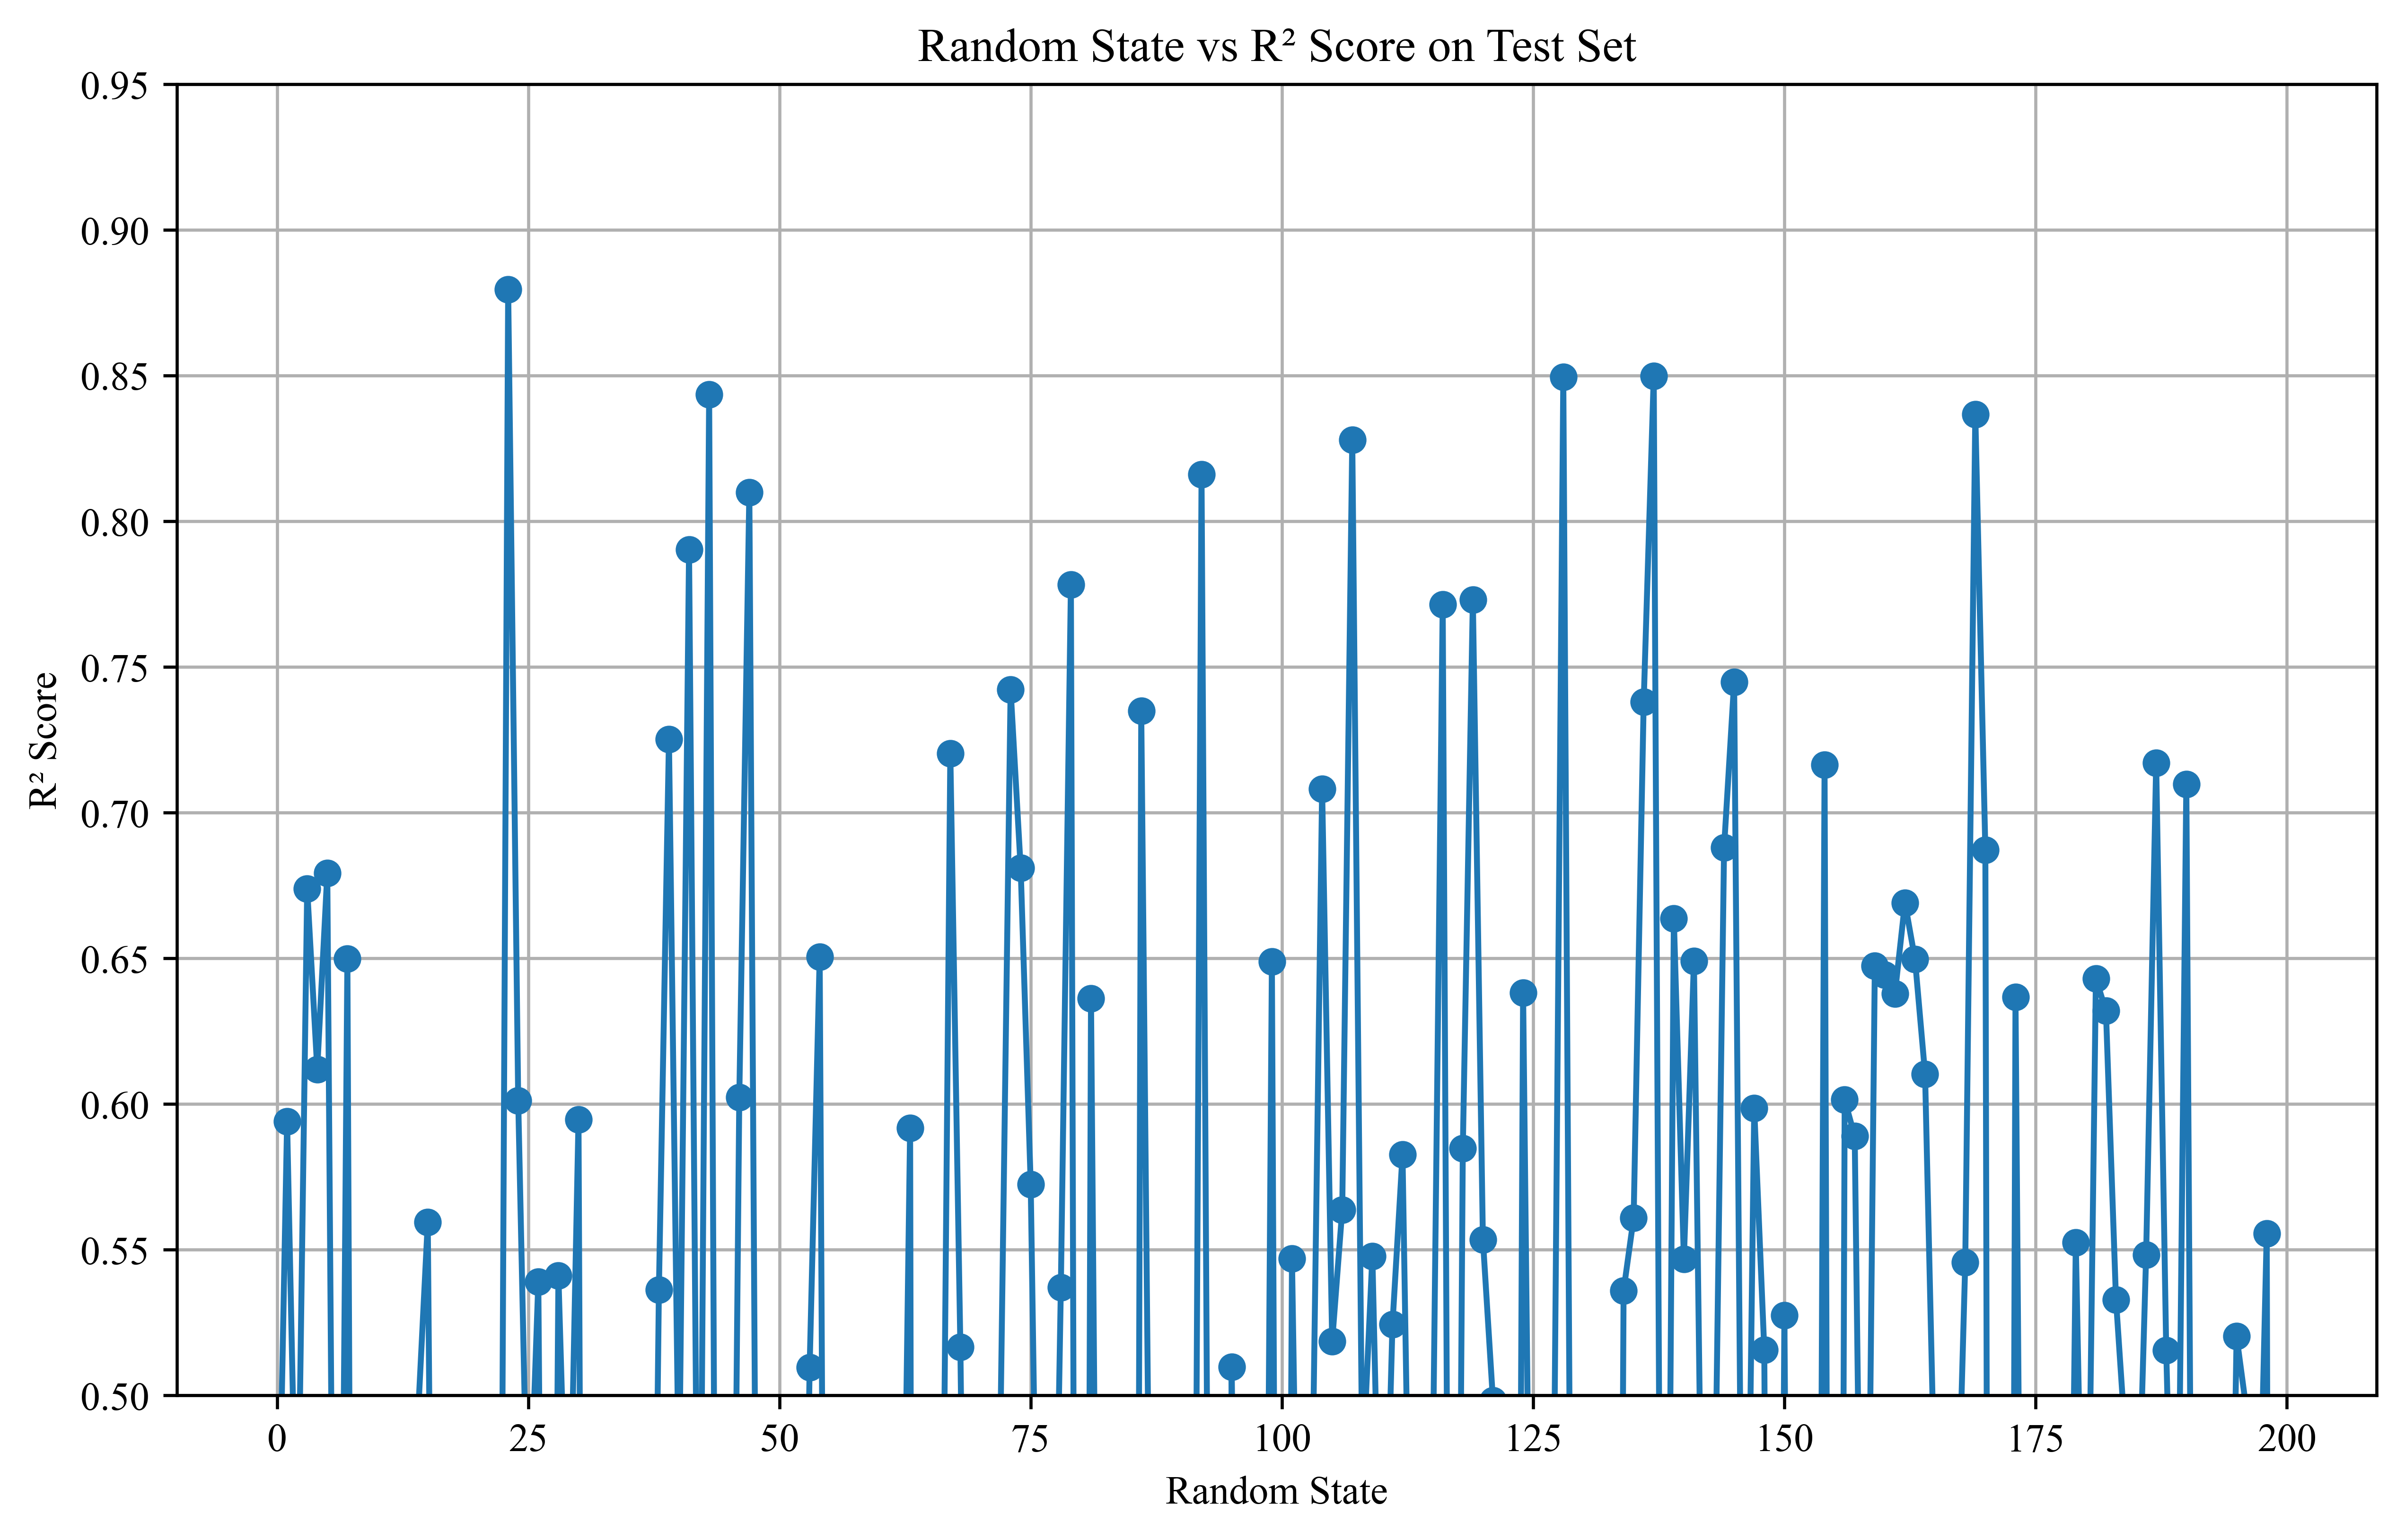

In [22]:
xgb_regressor = xgb.XGBRegressor()



# Empty lists to store random_state and corresponding R2
random_states = []
r2_scores = []

# Loop over 100 random states
for random_state in range(0, 200):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Grid search
    grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring=mae_scorer, cv=5, n_jobs=8)
    grid_search.fit(X_train, y_train)
    
    best_params_xgb = grid_search.best_params_
    
    # Train best model
    best_yld_xgb_model = xgb.XGBRegressor(**best_params_xgb)
    best_yld_xgb_model.fit(X_train, y_train)
    
    # Predict and calculate R2 on test set
    y_pred_xgb = best_yld_xgb_model.predict(X_test)
    r2_test_xgb = r2_score(y_test, y_pred_xgb)
    mae_test_xgb = mean_absolute_error(y_test, y_pred_xgb)
    
    # Store results
    random_states.append(random_state)
    r2_scores.append(r2_test_xgb)

# Plotting Random State vs R2
plt.figure(figsize=(10, 6))
plt.plot(random_states, r2_scores, marker='o')
plt.xlabel('Random State')
plt.ylim(.5,.95)
plt.ylabel('R² Score')
plt.title('Random State vs R² Score on Test Set')
plt.grid(True)
plt.show()


In [23]:
import numpy as np

# Convert to numpy array (if not already)
r2_scores_array = np.array(r2_scores)

# Get indices of top 5 highest R2 scores
top5_indices = np.argsort(r2_scores_array)[-5:][::-1]  # sort, pick last 5, then reverse

# Get the corresponding random states and R2 values
top5_random_states = [random_states[i] for i in top5_indices]
top5_r2_scores = [r2_scores[i] for i in top5_indices]

# Print them
for rs, r2 in zip(top5_random_states, top5_r2_scores):
    print(f'Random State: {rs}, R² Score: {r2:.4f}')

Random State: 23, R² Score: 0.8797
Random State: 137, R² Score: 0.8498
Random State: 128, R² Score: 0.8495
Random State: 43, R² Score: 0.8435
Random State: 169, R² Score: 0.8367
